# HAT Clustering Analysis — Emotional vs Neutral (Per-Prompt Isolated)

Each data point is one permutation run — a full inference over a concatenated sequence of stories,
isolated via server reset + cache drop before each trial.

**Data layout per data point** (`runs/<label>/p<NNNN>/`):
```
perf_stat.csv        — 1ms buckets, 24 perf events (HAT Layer 1 tracepoints + Layer 2 PMU/power)
hat_interrupts.csv   — 100ms: /proc/interrupts, /proc/softirqs, CPU freq per core
proc_sample.csv      — 100ms: system + per-process CPU jiffies, RSS
collector_meta.json  — t0_ns, duration, perf_events list
trial_meta.json      — prompt_index, label, ok, t_request_start_ns, t_request_end_ns, elapsed_ms
```

**Experimental design:**
- 120 emotional permutations (5! orderings of 5 ptsd
 stories)
- 120 neutral permutations (5! orderings of 5 WikiHow articles)
- Neutral prompts are shorter on average → `elapsed_ms` used as a confounder proxy for prompt length
- Each trial is fully isolated: server reset + `drop_caches` + 2s stabilisation baseline

**Analysis approach:**
1. Extract 10 indicator metrics per HAT indicator (event-specific or PCI-specific, as appropriate)
2. Build a feature matrix: 240 rows × N metrics
3. Per-metric univariate screening (Mann-Whitney U + effect size)
4. Per-metric k=2 clustering → silhouette score → rank metrics by separability
5. Multi-metric GMM clustering on top-K features
6. Confounder check: elapsed_ms (prompt duration proxy for length difference)
7. PCoA / UMAP visualisation


In [1]:
import json, re, warnings
from pathlib import Path
from collections import defaultdict
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as sp_stats

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (14, 5)

print('Imports OK')

Imports OK


## 1 — Configuration

In [2]:
# ── Set this to your mccviahat root ──
BASE_DIR = Path.home() / 'Desktop' / 'mccviahat'

NEUTRAL_ROOT   = BASE_DIR / 'runs' / 'trainingN' 
EMOTIONAL_ROOT = BASE_DIR / 'runs' / 'trainingE'

for d in [NEUTRAL_ROOT, EMOTIONAL_ROOT]:
    assert d.exists(), f'Missing run root: {d}'

n_trials = sorted(NEUTRAL_ROOT.glob('p????'))
e_trials = sorted(EMOTIONAL_ROOT.glob('p????'))

print(f'Neutral trials:   {len(n_trials)}')
print(f'Emotional trials: {len(e_trials)}')

Neutral trials:   120
Emotional trials: 120


## 2 — Loaders

Each data point is a directory. We load:
- `perf_stat.csv` (wide format, 1ms resolution) — event-indicators + PCIs from perf
- `hat_interrupts.csv` (100ms) — cumulative /proc/interrupts counters, converted to deltas
- `trial_meta.json` — elapsed_ms (used as confounder for prompt length)

In [3]:
def load_trial_meta(trial_dir: Path) -> dict:
    p = trial_dir / 'trial_meta.json'
    return json.loads(p.read_text()) if p.exists() else {}


def load_collector_meta(trial_dir: Path) -> dict:
    p = trial_dir / 'collector_meta.json'
    return json.loads(p.read_text()) if p.exists() else {}


def load_perf(trial_dir: Path) -> pd.DataFrame | None:
    """Load perf_stat.csv (wide: t_s, event1, ...). Falls back to parsing perf_stat.txt."""
    csv_p = trial_dir / 'perf_stat.csv'
    txt_p = trial_dir / 'perf_stat.txt'
    if csv_p.exists() and csv_p.stat().st_size > 0:
        return pd.read_csv(csv_p)
    if txt_p.exists() and txt_p.stat().st_size > 0:
        return _parse_perf_txt(txt_p)
    return None


def _parse_perf_txt(path: Path) -> pd.DataFrame:
    """Parse perf stat -x ',' output into wide DataFrame."""
    from collections import OrderedDict
    rows_by_ts: dict = OrderedDict()
    events_seen: list = []
    for line in path.read_text(encoding='utf-8', errors='replace').splitlines():
        line = line.strip()
        if not line or line.startswith('#'):
            continue
        parts = line.split(',')
        if len(parts) < 4:
            continue
        try:
            ts = float(parts[0])
        except ValueError:
            continue
        event = parts[3].strip()
        if not event:
            continue
        val_s = parts[1].strip()
        val = float('nan') if (val_s.startswith('<') or val_s == '') else float(val_s) if val_s.replace('.','',1).isdigit() else float('nan')
        if event not in events_seen:
            events_seen.append(event)
        rows_by_ts.setdefault(ts, {})[event] = val
    records = [{'t_s': ts, **evts} for ts, evts in rows_by_ts.items()]
    df = pd.DataFrame(records).sort_values('t_s').reset_index(drop=True)
    return df


def load_hat_interrupts(trial_dir: Path) -> pd.DataFrame | None:
    """Load hat_interrupts.csv with cumulative counters converted to per-sample deltas."""
    p = trial_dir / 'hat_interrupts.csv'
    if not p.exists() or p.stat().st_size == 0:
        return None
    df = pd.read_csv(p)
    df['t_s'] = (df['timestamp_ns'] - df['timestamp_ns'].iloc[0]) / 1e9
    # Convert cumulative /proc/interrupts counts to deltas (rate per sample)
    irq_cols = [c for c in df.columns
                if c not in ('timestamp_ns', 't_s')
                and not c.endswith('_freq_khz')
                and pd.api.types.is_numeric_dtype(df[c])]
    for c in irq_cols:
        df[c] = df[c].diff().clip(lower=0)  # deltas; first row becomes NaN → drop later
    df = df.iloc[1:].reset_index(drop=True)  # drop first NaN row
    return df


print('Loaders defined')

Loaders defined


## 3 — Metric definitions

We compute **10 metrics** per indicator, split by indicator type:

| # | Metric | Applies to | Description |
|---|--------|------------|-------------|
| 1 | `mean_rate` | both | Mean count/value per time unit |
| 2 | `variance` | both (PCIs esp.) | Spread around the mean |
| 3 | `p90_p10` | both | Robust range (P90 − P10) |
| 4 | `slope` | PCIs esp. | Linear trend (drift during inference) |
| 5 | `spectral_entropy` | PCIs esp. | PSD entropy — structured vs broadband |
| 6 | `iat_cv` | event-indicators | Coefficient of variation of inter-arrival times |
| 7 | `burst_rate` | event-indicators | Bursts (runs > mean+1σ) per second |
| 8 | `burst_clustering` | event-indicators | Fraction of events inside bursts |
| 9 | `lz_complexity` | both | Lempel-Ziv complexity (binarised) |
| 10 | `perm_entropy` | both | Normalised permutation entropy (order=3) |

**Neutral prompts are shorter** → elapsed_ms differs systematically. We record it as a confounder
and use it to check that any detected separation is not purely a length artifact.

In [4]:
# ─── Metric helpers ───────────────────────────────────────────────────────────

def _safe(series: np.ndarray) -> np.ndarray:
    """Drop NaN/Inf, return float64."""
    s = np.asarray(series, dtype=float)
    return s[np.isfinite(s)]


def metric_mean_rate(s: np.ndarray, dt_s: float) -> float:
    """Mean count per second (event-indicators) or mean value (PCIs)."""
    s = _safe(s)
    return float(s.mean() / dt_s) if (len(s) > 0 and dt_s > 0) else np.nan


def metric_variance(s: np.ndarray) -> float:
    s = _safe(s)
    return float(np.var(s, ddof=1)) if len(s) > 1 else np.nan


def metric_p90_p10(s: np.ndarray) -> float:
    s = _safe(s)
    return float(np.percentile(s, 90) - np.percentile(s, 10)) if len(s) > 1 else np.nan


def metric_slope(s: np.ndarray) -> float:
    """OLS slope (value per sample)."""
    s = _safe(s)
    if len(s) < 3:
        return np.nan
    x = np.arange(len(s), dtype=float)
    return float(np.polyfit(x, s, 1)[0])


def metric_spectral_entropy(s: np.ndarray) -> float:
    """Normalised Shannon entropy of power spectral density."""
    s = _safe(s)
    if len(s) < 4:
        return np.nan
    psd = np.abs(np.fft.rfft(s - s.mean())) ** 2
    psd = psd[1:]  # skip DC
    if psd.sum() == 0:
        return 0.0
    p = psd / psd.sum()
    h = -np.sum(p * np.log2(p + 1e-15))
    return float(h / np.log2(len(p))) if len(p) > 1 else 0.0


def metric_iat_cv(s: np.ndarray) -> float:
    """CV of inter-arrival times (only meaningful for event-indicators)."""
    s = _safe(s)
    arrivals = np.where(s > 0)[0]
    if len(arrivals) < 3:
        return np.nan
    iat = np.diff(arrivals).astype(float)
    mu = iat.mean()
    return float(iat.std(ddof=1) / mu) if mu > 0 else np.nan


def metric_burst_rate(s: np.ndarray, dur_s: float) -> float:
    """Bursts (contiguous runs above mean+1σ) per second."""
    s = _safe(s)
    if len(s) < 2 or s.std() == 0:
        return 0.0
    thresh = s.mean() + s.std()
    above = (s > thresh).astype(int)
    diff = np.diff(np.concatenate(([0], above, [0])))
    n_bursts = int((diff == 1).sum())
    return float(n_bursts / dur_s) if dur_s > 0 else 0.0


def metric_burst_clustering(s: np.ndarray) -> float:
    """Fraction of total events that fall inside bursts."""
    s = _safe(s)
    if len(s) < 2 or s.std() == 0 or s.sum() == 0:
        return 0.0
    thresh = s.mean() + s.std()
    above = (s > thresh).astype(int)
    diff = np.diff(np.concatenate(([0], above, [0])))
    starts = np.where(diff == 1)[0]
    ends   = np.where(diff == -1)[0]
    if len(starts) == 0:
        return 0.0
    events_in_bursts = sum(s[st:en].sum() for st, en in zip(starts, ends))
    return float(events_in_bursts / s.sum())


def metric_lz_complexity(s: np.ndarray) -> float:
    """LZ76 complexity of binarised (> median) series, normalised."""
    s = _safe(s)
    if len(s) < 4:
        return np.nan
    binary = (s > np.median(s)).astype(int)
    seq = ''.join(map(str, binary))
    n = len(seq)
    i, k, l, c = 0, 1, 1, 1
    while k + l <= n:
        if seq[i + l - 1] == seq[k + l - 1]:
            l += 1
        else:
            i += 1
            if i == k:
                c += 1; k += l; i = 0; l = 1
            else:
                l = 1
    c += 1
    return float(c / (n / np.log2(n))) if n > 1 else 0.0


def metric_perm_entropy(s: np.ndarray, order: int = 3) -> float:
    """Normalised permutation entropy."""
    import math
    s = _safe(s)
    if len(s) < order:
        return np.nan
    counts = defaultdict(int)
    for i in range(len(s) - order + 1):
        counts[tuple(np.argsort(s[i:i+order]))] += 1
    total = sum(counts.values())
    probs = np.array(list(counts.values())) / total
    h = -np.sum(probs * np.log2(probs + 1e-15))
    h_max = np.log2(math.factorial(order))
    return float(h / h_max) if h_max > 0 else 0.0


def compute_all_metrics(s: np.ndarray, dur_s: float, indicator_type: str = 'event') -> dict:
    """
    Compute all 10 metrics for one indicator series.
    indicator_type: 'event' (discrete, irregular) or 'pci' (periodic, continuous).
    Both types get all 10 metrics; IAT-based ones return NaN for PCIs (constant interval).
    """
    return {
        'mean_rate':        metric_mean_rate(s, dur_s),
        'variance':         metric_variance(s),
        'p90_p10':          metric_p90_p10(s),
        'slope':            metric_slope(s),
        'spectral_entropy': metric_spectral_entropy(s),
        'iat_cv':           metric_iat_cv(s) if indicator_type == 'event' else np.nan,
        'burst_rate':       metric_burst_rate(s, dur_s),
        'burst_clustering': metric_burst_clustering(s),
        'lz_complexity':    metric_lz_complexity(s),
        'perm_entropy':     metric_perm_entropy(s),
    }


print('Metric functions defined')

Metric functions defined


## 4 — Feature extraction

Loop over all trials, load their perf and HAT interrupt data, compute metrics for each indicator.
One row = one trial = one data point.

In [ ]:
# Classify perf events by indicator type
EVENT_INDICATORS = {
    'irq:irq_handler_entry', 'irq:irq_handler_exit',
    'irq:softirq_entry', 'irq:softirq_exit', 'irq:softirq_raise',
    'tlb:tlb_flush', 'mce:mce_record',
    'context-switches', 'cpu-migrations', 'page-faults',
}
# Everything else in perf is a PCI (counter read at fixed 1ms intervals)


def extract_trial_features(trial_dir: Path, label: str) -> dict | None:
    """Return a flat feature dict for one trial directory, or None on failure."""
    t_meta = load_trial_meta(trial_dir)
    if not t_meta.get('ok', False):
        return None  # failed trial

    perf = load_perf(trial_dir)
    if perf is None or len(perf) < 10:
        return None  # collector didn't produce usable data

    c_meta = load_collector_meta(trial_dir)
    dur_s = t_meta.get('elapsed_ms', np.nan) / 1000.0

    row = {
        'condition':   label,
        'prompt_index': t_meta.get('prompt_index', -1),
        'elapsed_ms':  t_meta.get('elapsed_ms', np.nan),
        'dur_s':       dur_s,
    }

    # ── perf indicators ──
    perf_events = [c for c in perf.columns if c != 't_s']
    for evt in perf_events:
        s = perf[evt].values.astype(float)
        itype = 'event' if evt in EVENT_INDICATORS else 'pci'
        metrics = compute_all_metrics(s, dur_s, itype)
        for m_name, m_val in metrics.items():
            row[f'{evt}__{m_name}'] = m_val

    # ── HAT interrupt indicators (delta counts at 100ms) ──
    hat = load_hat_interrupts(trial_dir)
    if hat is not None:
        hat_irq_cols = [
        c for c in hat.columns
        if c not in ('timestamp_ns', 't_s')
        and not c.endswith('_freq_khz')
        and pd.api.types.is_numeric_dtype(hat[c])
        and not c.isdigit()  # Exclude numeric IRQs
        and not (c.startswith('hat_') and c[4:].isdigit())  # Exclude hat_### IRQs
        ]
        hat_freq_cols = [c for c in hat.columns if c.endswith('_freq_khz')]

        for col in hat_irq_cols:
            s = hat[col].values.astype(float)
            metrics = compute_all_metrics(s, dur_s, 'event')
            for m_name, m_val in metrics.items():
                row[f'hat_{col}__{m_name}'] = m_val

        # CPU frequency: PCI at 100ms — mean and variance per trial
        if hat_freq_cols:
            freq_mean = hat[hat_freq_cols].mean(axis=1).values
            metrics = compute_all_metrics(freq_mean, dur_s, 'pci')
            for m_name, m_val in metrics.items():
                row[f'cpu_freq_mean__{m_name}'] = m_val

    return row


# ── Run extraction ──
print('Extracting features…')
records = []
skipped = 0

for trial_dir in n_trials:
    r = extract_trial_features(trial_dir, 'neutral')
    if r is not None:
        records.append(r)
    else:
        skipped += 1

for trial_dir in e_trials:
    r = extract_trial_features(trial_dir, 'emotional')
    if r is not None:
        records.append(r)
    else:
        skipped += 1

df_all = pd.DataFrame(records)
print(f'Loaded: {len(df_all)} trials ({skipped} skipped)')
print(f'  neutral:   {(df_all.condition == "neutral").sum()}')
print(f'  emotional: {(df_all.condition == "emotional").sum()}')
print(f'Feature columns: {len(df_all.columns) - 4}')

Extracting features…


## 5 — Confounder check: elapsed_ms

Neutral prompts are shorter. If elapsed_ms differs significantly between conditions,
any metric that scales with prompt duration is a confounder, not a true signal.
We check this explicitly and will flag length-sensitive metrics.

=== elapsed_ms (proxy for prompt length) ===
  Neutral:   mean=25364ms  std=194ms
  Emotional: mean=25395ms  std=63ms
  Mann-Whitney U p = 0.0605 (OK, balanced)


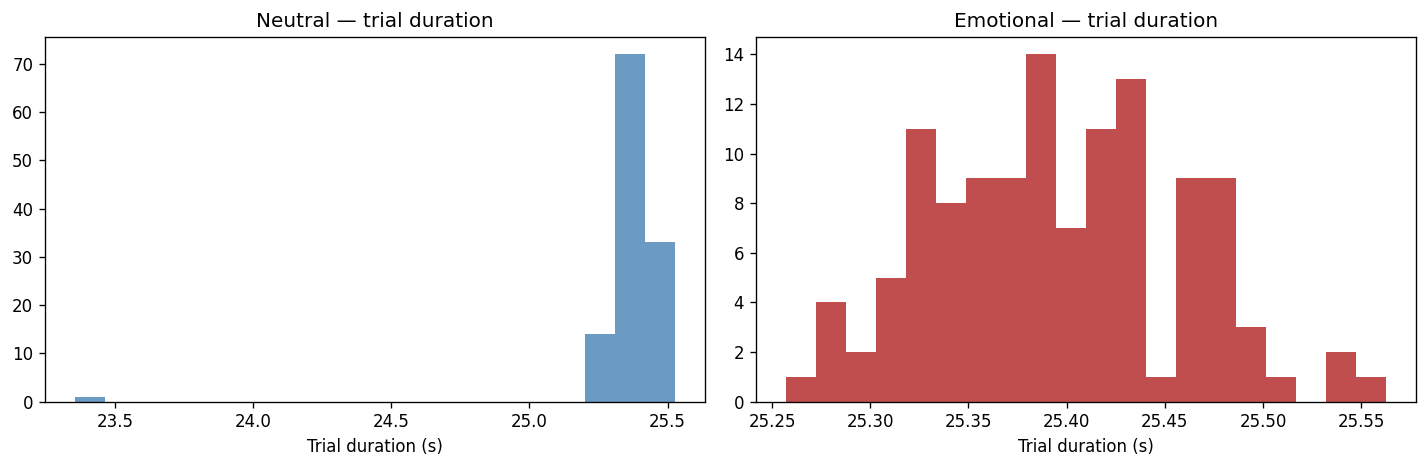


Length confound flag: False
Note: mean_rate is normalised by dur_s, so it is NOT confounded by length.
Metrics like burst_rate (per-second) are also duration-normalised.
Metrics like variance, p90_p10, lz_complexity may scale with duration → flag if sig.


In [ ]:
n_rows = df_all[df_all.condition == 'neutral']
e_rows = df_all[df_all.condition == 'emotional']

print('=== elapsed_ms (proxy for prompt length) ===')
print(f'  Neutral:   mean={n_rows.elapsed_ms.mean():.0f}ms  std={n_rows.elapsed_ms.std():.0f}ms')
print(f'  Emotional: mean={e_rows.elapsed_ms.mean():.0f}ms  std={e_rows.elapsed_ms.std():.0f}ms')
stat, p_len = sp_stats.mannwhitneyu(n_rows.elapsed_ms, e_rows.elapsed_ms, alternative='two-sided')
print(f'  Mann-Whitney U p = {p_len:.4f}', '← LENGTH DIFFERS SIGNIFICANTLY' if p_len < 0.05 else '(OK, balanced)')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, rows, label, color in [
    (axes[0], n_rows, 'Neutral',   'steelblue'),
    (axes[1], e_rows, 'Emotional', 'firebrick'),
]:
    ax.hist(rows.elapsed_ms / 1000, bins=20, color=color, alpha=0.8)
    ax.set_xlabel('Trial duration (s)')
    ax.set_title(f'{label} — trial duration')
plt.tight_layout()
plt.show()

LENGTH_CONFOUNDED = p_len < 0.05
print(f'\nLength confound flag: {LENGTH_CONFOUNDED}')
print('Note: mean_rate is normalised by dur_s, so it is NOT confounded by length.')
print('Metrics like burst_rate (per-second) are also duration-normalised.')
print('Metrics like variance, p90_p10, lz_complexity may scale with duration → flag if sig.')

In [ ]:
# --- Feature selection: include/exclude length-confounded features ---
from typing import List

# List of metrics that may be length-confounded
LENGTH_CONFOUNDED_METRICS = {
    'variance', 'p90_p10', 'lz_complexity', 'perm_entropy', 'spectral_entropy'
}

feature_cols = [c for c in df_all.columns if '__' in c]

def metric_of(col: str) -> str:
    # evt__metric
    return col.split('__', 1)[1]

length_confounded_cols   = [c for c in feature_cols if metric_of(c) in LENGTH_CONFOUNDED_METRICS]
length_unconfounded_cols = [c for c in feature_cols if metric_of(c) not in LENGTH_CONFOUNDED_METRICS]

print(f"Length-confounded features: {len(length_confounded_cols)}")
print(f"Length-unconfounded features: {len(length_unconfounded_cols)}")

# User selection: set to True to include, False to exclude length-confounded features
INCLUDE_LENGTH_CONFOUNDED = False  # <-- change this to True to include them

if INCLUDE_LENGTH_CONFOUNDED:
    selected_cols = length_unconfounded_cols + length_confounded_cols
    print("Including ALL features (length-confounded and unconfounded).")
else:
    selected_cols = length_unconfounded_cols
    print("Excluding length-confounded features.")

# Subset the feature matrix for downstream analysis
X = df_all[selected_cols].copy()
print(f"Final feature matrix shape: {X.shape}")

Length-confounded features: 270
Length-unconfounded features: 270
Excluding length-confounded features.
Final feature matrix shape: (240, 270)


In [ ]:
# --- Regress out token_count and elapsed_ms from all features ---
import re
from sklearn.linear_model import LinearRegression

# Calculate token_count for neutral prompts (first trial)
def count_tokens(text):
    return len(re.findall(r'\S+', text))

first_neutral_trial = n_trials[0]
prompt_path = first_neutral_trial / "trial_meta.json"
token_count_neutral = 0
if prompt_path.exists():
    with open(prompt_path, "r", encoding="utf-8") as f:
        meta = json.load(f)
        token_count_neutral = count_tokens(meta.get("instructions", ""))

# Assign token_count to all trials
if "token_count" not in df_all.columns:
    df_all["token_count"] = 0
    df_all.loc[df_all.condition == "neutral", "token_count"] = token_count_neutral

# Regress out token_count and elapsed_ms from all feature columns
feature_cols = [c for c in df_all.columns if '__' in c]
for col in feature_cols:
    y_feat = df_all[col].values
    X_reg = df_all[["token_count", "elapsed_ms"]].values
    mask = np.isfinite(y_feat) & np.isfinite(X_reg).all(axis=1)
    if mask.sum() < 10:
        continue
    reg = LinearRegression()
    reg.fit(X_reg[mask], y_feat[mask])
    y_pred = reg.predict(X_reg)
    df_all[col] = y_feat - y_pred  # Replace with residuals

print("Regressed out token_count and elapsed_ms from all features.")

Regressed out token_count and elapsed_ms from all features.



## 6 — Build feature matrix and clean

In [ ]:
# --- Build feature matrix and clean ---
# Use selected_cols from previous cell (already filtered for confounding)

META_COLS = {'condition', 'prompt_index', 'elapsed_ms', 'dur_s'}
feat_cols = [c for c in X.columns if c not in META_COLS]

X_raw = X[feat_cols].copy()
y = (df_all['condition'] == 'emotional').astype(int).values  # 0=neutral, 1=emotional

# Drop zero-variance columns and fill NaN
X_raw = X_raw.loc[:, X_raw.std() > 0]
X_raw = X_raw.fillna(X_raw.median())

feat_cols = list(X_raw.columns)
print(f'Feature matrix: {X_raw.shape[0]} samples × {X_raw.shape[1]} features')

# Standardise
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X_raw), columns=feat_cols)
print('Standardised.')

Feature matrix: 240 samples × 154 features
Standardised.


In [ ]:
# --- Diagnostics: Check feature selection logic ---
print(f"INCLUDE_LENGTH_CONFOUNDED = {INCLUDE_LENGTH_CONFOUNDED}")
print(f"Length-confounded features matched: {len(length_confounded_cols)}")
print(f"Length-unconfounded features matched: {len(length_unconfounded_cols)}")
print(f"Selected columns: {len(selected_cols)}")
print(f"First 10 selected columns: {selected_cols[:10]}")
print(f"Final feature matrix shape after cleaning: {X.shape}")

INCLUDE_LENGTH_CONFOUNDED = False
Length-confounded features matched: 270
Length-unconfounded features matched: 270
Selected columns: 270
First 10 selected columns: ['irq:irq_handler_entry__mean_rate', 'irq:irq_handler_entry__slope', 'irq:irq_handler_entry__iat_cv', 'irq:irq_handler_entry__burst_rate', 'irq:irq_handler_entry__burst_clustering', 'irq:irq_handler_exit__mean_rate', 'irq:irq_handler_exit__slope', 'irq:irq_handler_exit__iat_cv', 'irq:irq_handler_exit__burst_rate', 'irq:irq_handler_exit__burst_clustering']
Final feature matrix shape after cleaning: (240, 154)


## 7 — Univariate screening: Mann-Whitney U per metric

Non-parametric test for each feature. We report effect size (rank-biserial r) and direction.

In [ ]:
results = []
n_vals = X_raw[y == 0]
e_vals = X_raw[y == 1]

for col in feat_cols:
    nv = n_vals[col].dropna().values
    ev = e_vals[col].dropna().values
    if len(nv) < 5 or len(ev) < 5:
        continue
    if nv.std() == 0 and ev.std() == 0:
        continue
    stat, p = sp_stats.mannwhitneyu(nv, ev, alternative='two-sided')
    r = 1 - (2 * stat) / (len(nv) * len(ev))  # rank-biserial r
    results.append({
        'feature':   col,
        'U':         stat,
        'p':         p,
        'effect_r':  r,
        'n_mean':    nv.mean(),
        'e_mean':    ev.mean(),
        'direction': '↑E' if ev.mean() > nv.mean() else '↓E',
    })

mwu_df = pd.DataFrame(results).sort_values('p').reset_index(drop=True)

# Bonferroni-corrected threshold
alpha_raw = 0.05
alpha_bonf = alpha_raw / len(mwu_df)
sig_strict = mwu_df[mwu_df.p < alpha_bonf]
sig_nominal = mwu_df[mwu_df.p < alpha_raw]

print(f'Features tested: {len(mwu_df)}')
print(f'Significant at p<{alpha_raw} (nominal):    {len(sig_nominal)}')
print(f'Significant at p<{alpha_bonf:.2e} (Bonferroni): {len(sig_strict)}')
print()
print('=== Top 30 features by p-value ===')
print(mwu_df.head(30)[['feature', 'U', 'p', 'effect_r', 'direction']].to_string(
    index=False, float_format='{:.4f}'.format))

Features tested: 154
Significant at p<0.05 (nominal):    56
Significant at p<3.25e-04 (Bonferroni): 25

=== Top 30 features by p-value ===
                              feature          U      p  effect_r direction
               page-faults__mean_rate 12769.0000 0.0000   -0.7735        ↓E
              page-faults__burst_rate 12450.0000 0.0000   -0.7292        ↓E
      irq:irq_handler_exit__mean_rate 12428.0000 0.0000   -0.7261        ↓E
     irq:irq_handler_entry__mean_rate 12428.0000 0.0000   -0.7261        ↓E
                hat_NET_RX__mean_rate 12302.0000 0.0000   -0.7086        ↓E
        page-faults__burst_clustering 12059.0000 0.0000   -0.6749        ↓E
          dTLB-load-misses__mean_rate 11912.0000 0.0000   -0.6544        ↓E
    irq:irq_handler_entry__burst_rate 11758.0000 0.0000   -0.6331        ↓E
     irq:irq_handler_exit__burst_rate 11758.0000 0.0000   -0.6331        ↓E
             instructions__burst_rate 10627.0000 0.0000   -0.4760        ↓E
                 hat_TIME

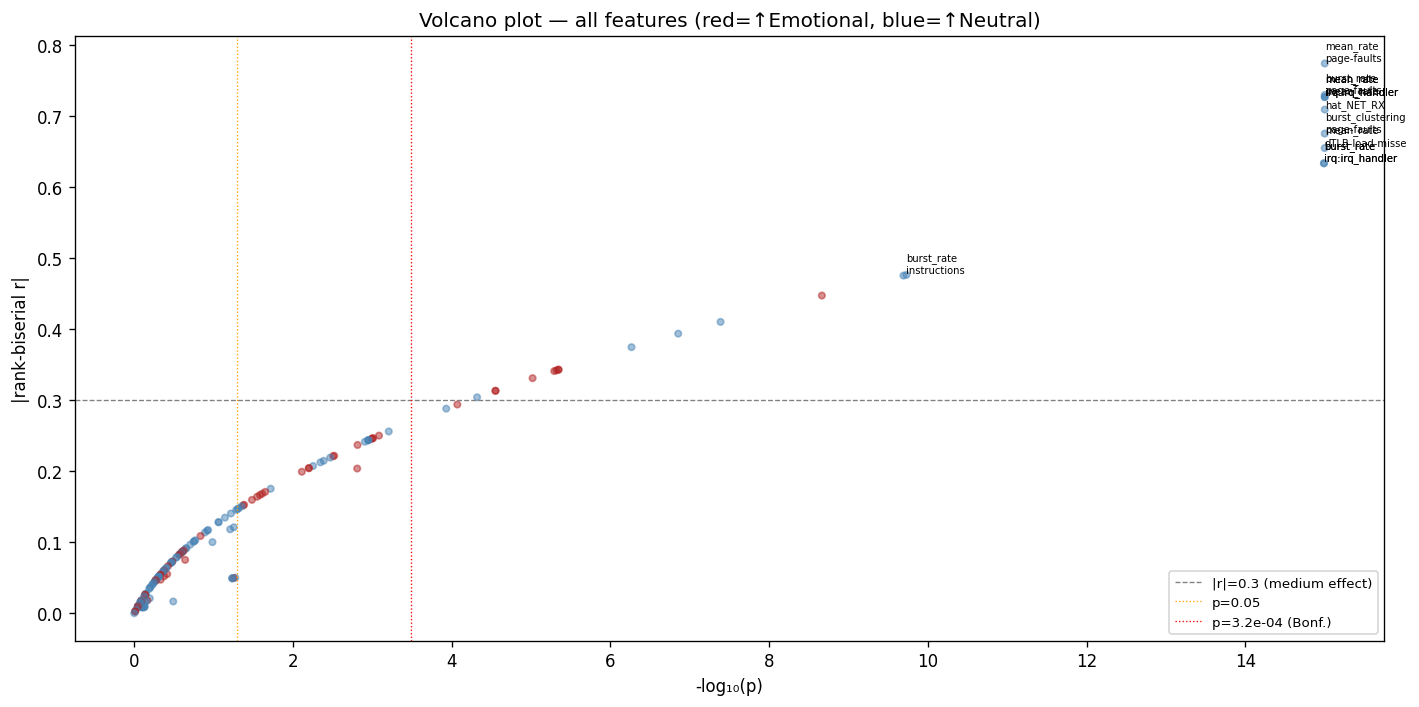

In [ ]:
# Volcano plot: effect size vs -log10(p)
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['firebrick' if r > 0 else 'steelblue' for r in mwu_df.effect_r]
ax.scatter(-np.log10(mwu_df.p + 1e-15), mwu_df.effect_r.abs(),
           c=colors, alpha=0.5, s=15)
ax.axhline(0.3, ls='--', color='gray', lw=0.8, label='|r|=0.3 (medium effect)')
ax.axvline(-np.log10(alpha_raw), ls=':', color='orange', lw=0.8, label=f'p={alpha_raw}')
ax.axvline(-np.log10(alpha_bonf), ls=':', color='red', lw=0.8, label=f'p={alpha_bonf:.1e} (Bonf.)')
# Label top 10
for _, row in mwu_df.head(10).iterrows():
    ax.annotate(row.feature.split('__')[-1] + '\n' + row.feature.split('__')[0][:15],
                xy=(-np.log10(row.p + 1e-15), abs(row.effect_r)),
                fontsize=6, ha='left', va='bottom')
ax.set_xlabel('-log₁₀(p)')
ax.set_ylabel('|rank-biserial r|')
ax.set_title('Volcano plot — all features (red=↑Emotional, blue=↑Neutral)')
ax.legend(fontsize=8)
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_volcano.png', dpi=150, bbox_inches='tight')
plt.show()

## 8 — Per-metric k=2 clustering → silhouette ranking

For each feature independently, fit k-means with k=2 and score how well the
resulting clusters align with the ground-truth labels.

Two scores per feature:
- **Silhouette**: geometric cluster quality (−1 to 1, higher = more separated)
- **ARI** (Adjusted Rand Index): overlap with true labels (0=random, 1=perfect)

In [ ]:
cluster_results = []

for col in feat_cols:
    x1d = X[[col]].values
    if np.isnan(x1d).any():
        continue
    km = KMeans(n_clusters=2, random_state=42, n_init=10)
    labels_pred = km.fit_predict(x1d)
    sil = silhouette_score(x1d, labels_pred)
    ari = adjusted_rand_score(y, labels_pred)
    # Cluster purity: fraction of majority label in each cluster
    mask0 = labels_pred == 0
    mask1 = labels_pred == 1
    purity = max(
        (y[mask0] == 0).mean() if mask0.sum() > 0 else 0,
        (y[mask0] == 1).mean() if mask0.sum() > 0 else 0,
    ) * 0.5 + max(
        (y[mask1] == 0).mean() if mask1.sum() > 0 else 0,
        (y[mask1] == 1).mean() if mask1.sum() > 0 else 0,
    ) * 0.5
    cluster_results.append({
        'feature':   col,
        'silhouette': sil,
        'ari':       ari,
        'purity':    purity,
    })

clust_df = pd.DataFrame(cluster_results).sort_values('silhouette', ascending=False).reset_index(drop=True)
print('=== Top 30 features by silhouette score ===')
print(clust_df.head(30).to_string(index=False, float_format='{:.4f}'.format))

=== Top 30 features by silhouette score ===
                           feature  silhouette     ari  purity
         hat_MCP__burst_clustering      1.0000 -0.0010  0.5158
      hat_NET_TX__burst_clustering      1.0000  0.0018  0.6565
       hat_BLOCK__burst_clustering      1.0000 -0.0007  0.5238
     hat_TASKLET__burst_clustering      1.0000  0.0018  0.5406
         hat_TLB__burst_clustering      1.0000 -0.0017  0.5180
         hat_IWI__burst_clustering      1.0000  0.0063  0.5556
               hat_MCP__burst_rate      0.9998 -0.0010  0.5158
                hat_MCP__mean_rate      0.9996 -0.0010  0.5158
              hat_BLOCK__mean_rate      0.9943 -0.0007  0.5238
            hat_NET_TX__burst_rate      0.9936  0.0018  0.6565
           hat_TASKLET__burst_rate      0.9922  0.0018  0.5406
                   hat_IWI__iat_cv      0.9907  0.0000  0.7510
                 hat_NET_TX__slope      0.9898  0.0000  0.7510
             hat_NET_TX__mean_rate      0.9890  0.0000  0.7510
           

In [ ]:
# Combine MWU p-value and silhouette into one ranking table
ranking = mwu_df[['feature', 'p', 'effect_r', 'direction']].merge(
    clust_df[['feature', 'silhouette', 'ari', 'purity']], on='feature', how='inner')

# Composite score: (1 - normalised_p_rank) * 0.5 + silhouette_rank * 0.5
ranking['p_rank']   = ranking['p'].rank()
ranking['sil_rank'] = (-ranking['silhouette']).rank()  # lower is better
ranking['composite_rank'] = ranking[['p_rank', 'sil_rank']].mean(axis=1)
ranking = ranking.sort_values('composite_rank').reset_index(drop=True)

print('=== Combined ranking (MWU + silhouette) — top 30 ===')
print(ranking.head(30)[['feature','p','effect_r','direction','silhouette','ari','purity']]
      .to_string(index=False, float_format='{:.4f}'.format))

# Save full ranking
ranking.to_csv(BASE_DIR / 'metric_ranking.csv', index=False)
print(f'\nSaved → {BASE_DIR}/metric_ranking.csv')

=== Combined ranking (MWU + silhouette) — top 30 ===
                           feature      p  effect_r direction  silhouette    ari  purity
       dTLB-load-misses__mean_rate 0.0000   -0.6544        ↓E      0.9797 0.0000  0.7510
           dTLB-load-misses__slope 0.0000   -0.3933        ↓E      0.9778 0.0000  0.7510
          tlb:tlb_flush__mean_rate 0.0000   -0.3037        ↓E      0.9763 0.0000  0.7510
context-switches__burst_clustering 0.0063    0.2040        ↑E      0.9869 0.0000  0.7510
      hat_NET_TX__burst_clustering 0.0534   -0.0500        ↓E      1.0000 0.0018  0.6565
  cpu-migrations__burst_clustering 0.0223    0.1707        ↑E      0.9868 0.0000  0.7510
            page-faults__mean_rate 0.0000   -0.7735        ↓E      0.8987 0.0001  0.7521
    cache-misses__burst_clustering 0.0077    0.1990        ↑E      0.9771 0.0000  0.7510
            hat_NET_TX__burst_rate 0.0583   -0.0490        ↓E      0.9936 0.0018  0.6565
         hat_IWI__burst_clustering 0.1034   -0.1000      

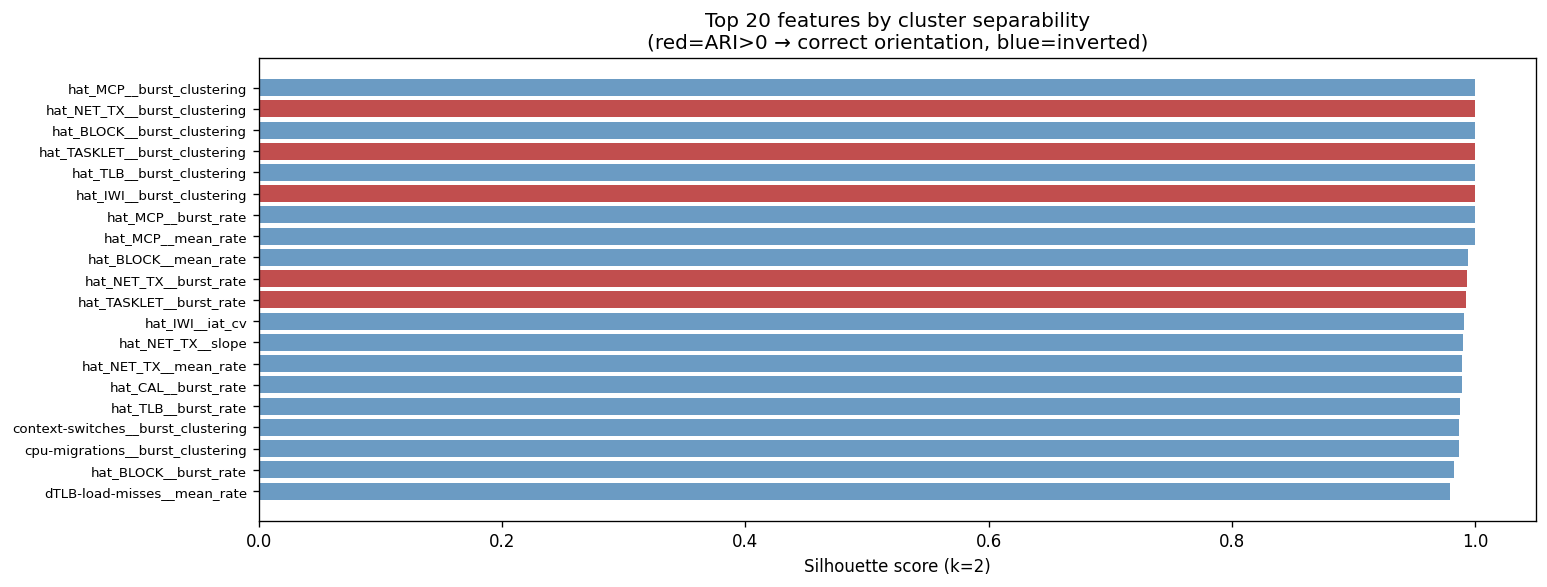

In [ ]:
# Bar chart: top 20 features by silhouette
top20 = clust_df.head(20)
fig, ax = plt.subplots(figsize=(13, 5))
colors = ['firebrick' if row.ari > 0 else 'steelblue'
          for _, row in top20.iterrows()]
ax.barh(range(len(top20)), top20.silhouette, color=colors, alpha=0.8)
ax.set_yticks(range(len(top20)))
ax.set_yticklabels(top20.feature, fontsize=8)
ax.invert_yaxis()
ax.set_xlabel('Silhouette score (k=2)')
ax.set_title('Top 20 features by cluster separability\n(red=ARI>0 → correct orientation, blue=inverted)')
ax.axvline(0, color='black', lw=0.5)
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_silhouette_ranking.png', dpi=150, bbox_inches='tight')
plt.show()

## 9 — Per-indicator metric summary

Which metric type (mean_rate, variance, burst_clustering, …) drives the most separable features?
Aggregate silhouette scores by metric suffix.

=== Metric type summary ===
          metric  n_features  mean_sil  max_sil  mean_ari              best_feature
       mean_rate          37    0.8567   0.9996    0.0337        hat_MCP__mean_rate
           slope          37    0.7784   0.9898    0.0069         hat_NET_TX__slope
burst_clustering          35    0.7155   1.0000    0.0153 hat_MCP__burst_clustering
      burst_rate          37    0.6914   0.9998    0.0315       hat_MCP__burst_rate
          iat_cv           8    0.6085   0.9907    0.0200           hat_IWI__iat_cv


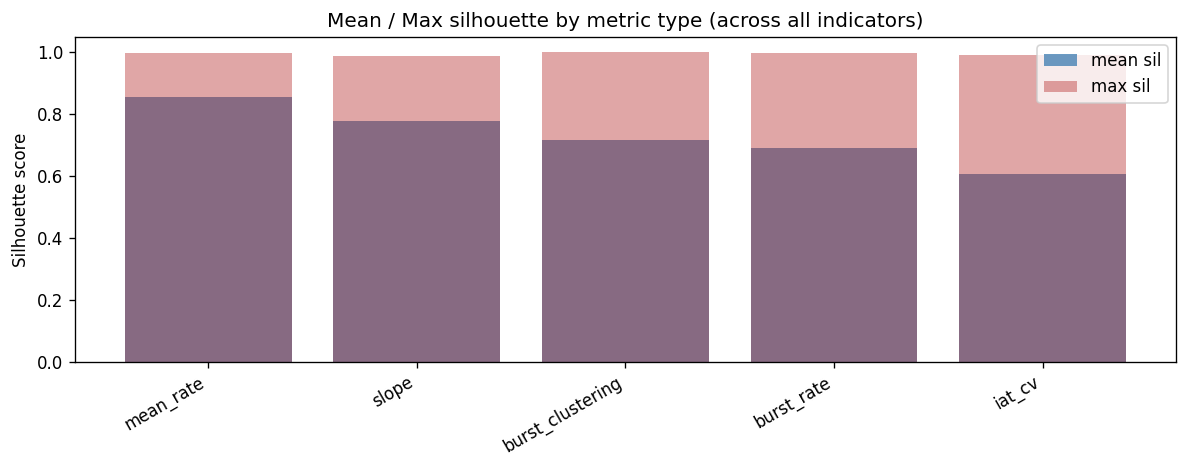

In [ ]:
METRIC_NAMES = ['mean_rate','variance','p90_p10','slope','spectral_entropy',
                'iat_cv','burst_rate','burst_clustering','lz_complexity','perm_entropy']

metric_agg = []
for m in METRIC_NAMES:
    rows = clust_df[clust_df.feature.str.endswith(f'__{m}')]
    if len(rows) == 0:
        continue
    metric_agg.append({
        'metric':       m,
        'n_features':   len(rows),
        'mean_sil':     rows.silhouette.mean(),
        'max_sil':      rows.silhouette.max(),
        'mean_ari':     rows.ari.mean(),
        'best_feature': rows.iloc[0].feature,
    })

metric_agg_df = pd.DataFrame(metric_agg).sort_values('mean_sil', ascending=False)
print('=== Metric type summary ===')
print(metric_agg_df.to_string(index=False, float_format='{:.4f}'.format))

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(metric_agg_df.metric, metric_agg_df.mean_sil, alpha=0.8, color='steelblue', label='mean sil')
ax.bar(metric_agg_df.metric, metric_agg_df.max_sil, alpha=0.4, color='firebrick', label='max sil')
ax.set_ylabel('Silhouette score')
ax.set_title('Mean / Max silhouette by metric type (across all indicators)')
ax.legend()
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_metric_type_summary.png', dpi=150, bbox_inches='tight')
plt.show()

## 10 — GMM clustering on top-K features

Select the top K features by composite rank, fit a 2-component GMM, and evaluate
cluster assignment against ground-truth labels.

In [ ]:
TOP_K = 24 # adjust after inspecting ranking

top_features = ranking.head(TOP_K)['feature'].tolist()
X_top = X[top_features].values

# GMM with k=2
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42, n_init=10)
gmm.fit(X_top)
gmm_labels = gmm.predict(X_top)
gmm_probs  = gmm.predict_proba(X_top)

ari_gmm  = adjusted_rand_score(y, gmm_labels)
sil_gmm  = silhouette_score(X_top, gmm_labels)

# Align GMM label 0/1 to neutral/emotional
# (GMM labels are arbitrary — check which assignment gives better accuracy)
acc_direct  = (gmm_labels == y).mean()
acc_flipped = (1 - gmm_labels == y).mean()
if acc_flipped > acc_direct:
    gmm_labels = 1 - gmm_labels
    gmm_probs  = gmm_probs[:, ::-1]
accuracy = (gmm_labels == y).mean()

print(f'GMM (k=2) on top {TOP_K} features:')
print(f'  ARI:      {ari_gmm:.4f}')
print(f'  Silhouette: {sil_gmm:.4f}')
print(f'  Accuracy vs ground truth: {accuracy:.1%}')
print(f'  Neutral correctly assigned:   {(gmm_labels[y==0] == 0).mean():.1%}')
print(f'  Emotional correctly assigned: {(gmm_labels[y==1] == 1).mean():.1%}')

GMM (k=2) on top 24 features:
  ARI:      0.0262
  Silhouette: 0.3108
  Accuracy vs ground truth: 58.3%
  Neutral correctly assigned:   19.2%
  Emotional correctly assigned: 97.5%


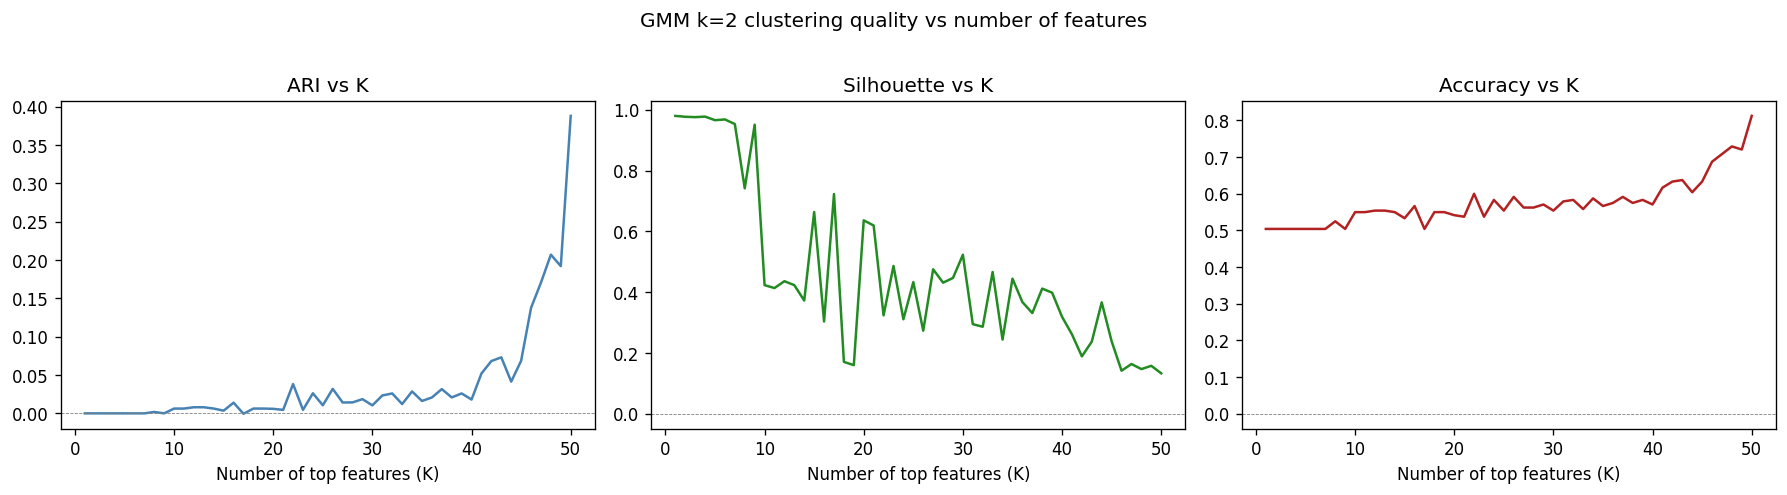

In [ ]:
# Sweep K from 1 to 50: how does clustering quality scale with number of features?
K_vals = list(range(1, min(51, len(feat_cols) + 1)))
ari_vals, sil_vals, acc_vals = [], [], []

for k in K_vals:
    feats = ranking.head(k)['feature'].tolist()
    Xk = X[feats].values
    try:
        gmm_k = GaussianMixture(n_components=2, covariance_type='full', random_state=42, n_init=5)
        lbl = gmm_k.fit_predict(Xk)
        ari_k = adjusted_rand_score(y, lbl)
        sil_k = silhouette_score(Xk, lbl) if len(np.unique(lbl)) > 1 else 0.0
        acc_k = max((lbl == y).mean(), (1 - lbl == y).mean())
        ari_vals.append(ari_k); sil_vals.append(sil_k); acc_vals.append(acc_k)
    except Exception:
        ari_vals.append(np.nan); sil_vals.append(np.nan); acc_vals.append(np.nan)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, vals, title, color in [
    (axes[0], ari_vals,  'ARI vs K',        'steelblue'),
    (axes[1], sil_vals,  'Silhouette vs K', 'forestgreen'),
    (axes[2], acc_vals,  'Accuracy vs K',   'firebrick'),
]:
    ax.plot(K_vals, vals, color=color, lw=1.5)
    ax.axhline(0, color='gray', lw=0.5, ls='--')
    ax.set_xlabel('Number of top features (K)')
    ax.set_title(title)

plt.suptitle('GMM k=2 clustering quality vs number of features', fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_k_sweep.png', dpi=150, bbox_inches='tight')
plt.show()

## 11 — PCA visualisation of cluster structure

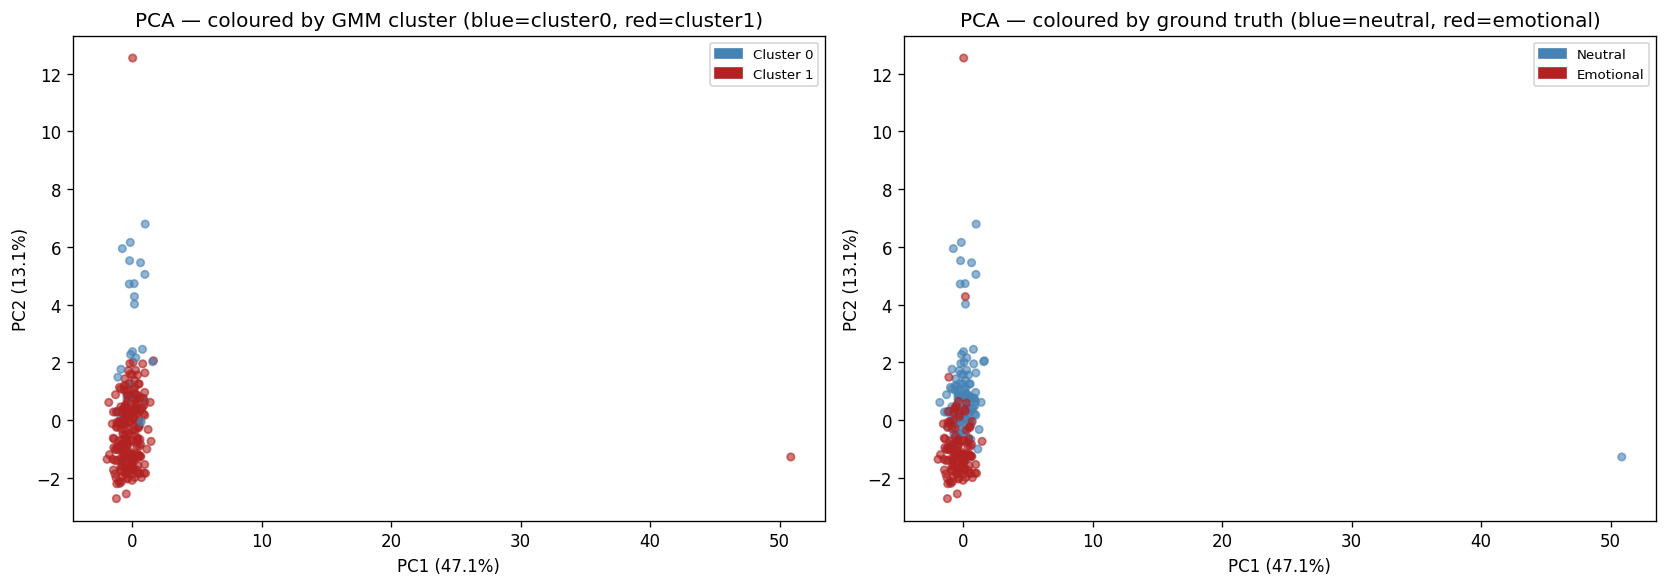

PCA explained variance: PC1=47.1%, PC2=13.1%


In [ ]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X[top_features].values)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: colour by GMM cluster assignment
ax = axes[0]
colors_pred = ['steelblue' if l == 0 else 'firebrick' for l in gmm_labels]
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=colors_pred, alpha=0.6, s=20)
ax.set_title('PCA — coloured by GMM cluster (blue=cluster0, red=cluster1)')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')

# Right: colour by ground truth
ax = axes[1]
gt_colors = ['steelblue' if yi == 0 else 'firebrick' for yi in y]
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=gt_colors, alpha=0.6, s=20)
ax.set_title('PCA — coloured by ground truth (blue=neutral, red=emotional)')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')

# Custom legends
from matplotlib.patches import Patch
axes[0].legend(handles=[Patch(color='steelblue', label='Cluster 0'),
                         Patch(color='firebrick', label='Cluster 1')], fontsize=8)
axes[1].legend(handles=[Patch(color='steelblue', label='Neutral'),
                         Patch(color='firebrick', label='Emotional')], fontsize=8)

plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_pca_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'PCA explained variance: PC1={pca.explained_variance_ratio_[0]:.1%}, PC2={pca.explained_variance_ratio_[1]:.1%}')

## 12 — Feature correlation matrix (top features)

Identify redundant features. Correlated features (|r|>0.9) carry overlapping information
and should be pruned to one representative per cluster.

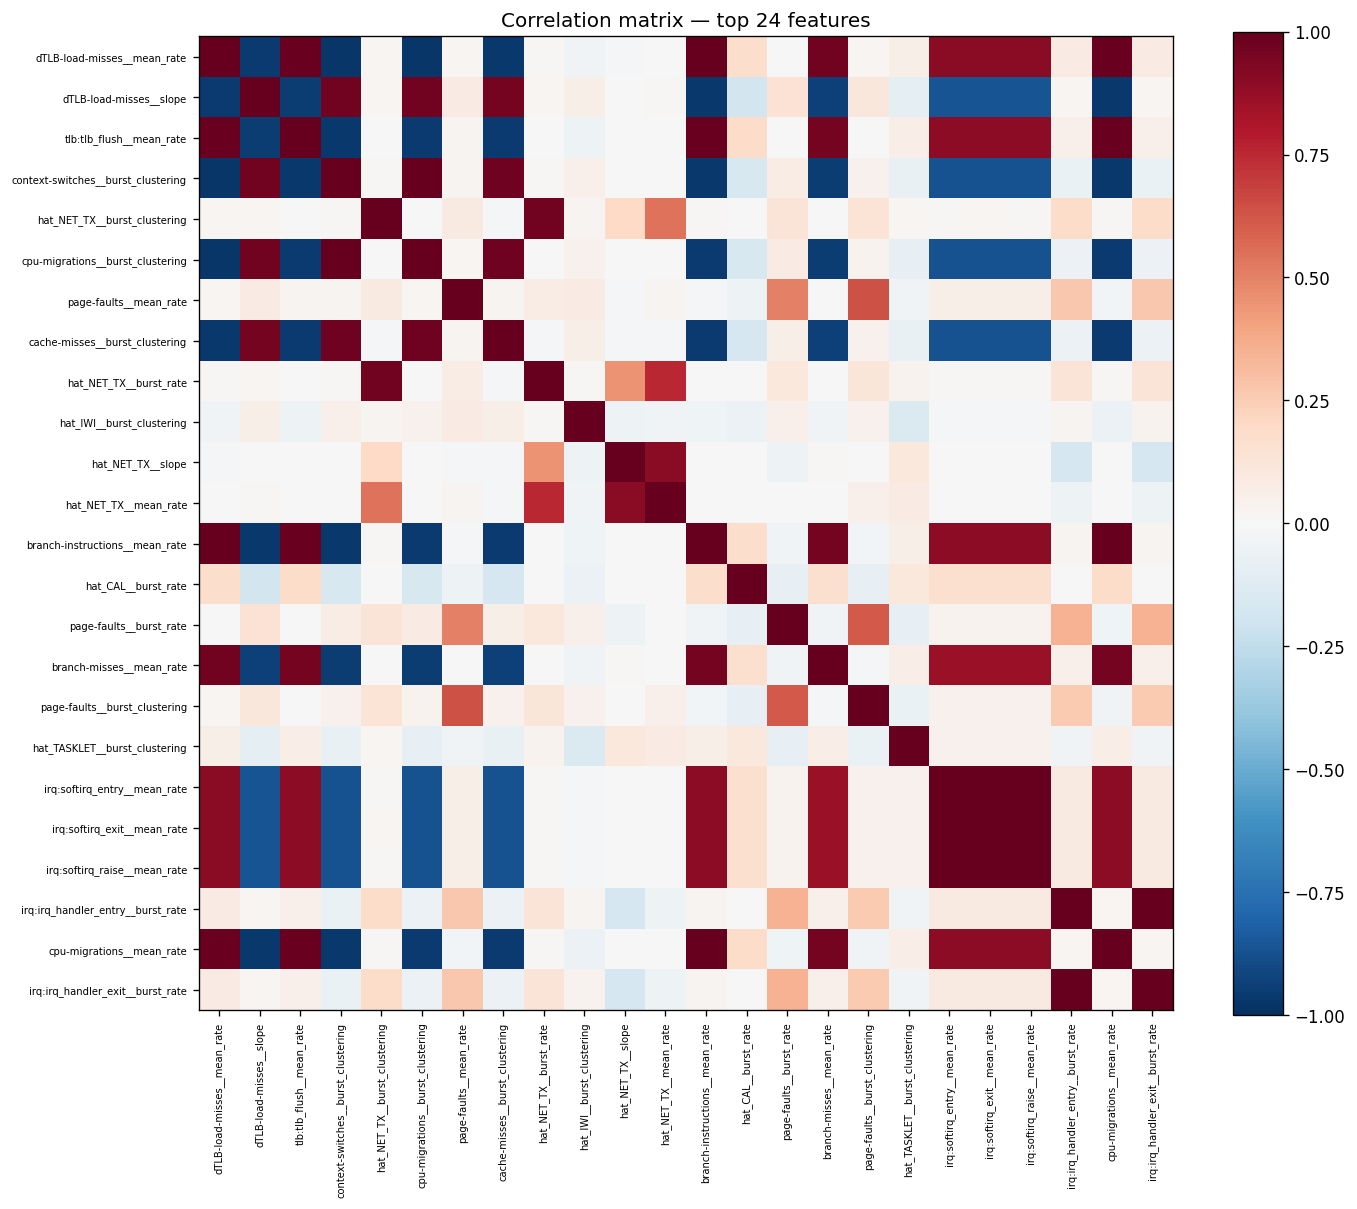

Highly correlated pairs (|r|>0.9): 45
                         feature_A                          feature_B      r
       dTLB-load-misses__mean_rate            dTLB-load-misses__slope -0.958
       dTLB-load-misses__mean_rate           tlb:tlb_flush__mean_rate  0.987
       dTLB-load-misses__mean_rate context-switches__burst_clustering -0.975
       dTLB-load-misses__mean_rate   cpu-migrations__burst_clustering -0.971
       dTLB-load-misses__mean_rate     cache-misses__burst_clustering -0.967
       dTLB-load-misses__mean_rate     branch-instructions__mean_rate  0.993
       dTLB-load-misses__mean_rate           branch-misses__mean_rate  0.963
       dTLB-load-misses__mean_rate       irq:softirq_entry__mean_rate  0.903
       dTLB-load-misses__mean_rate        irq:softirq_exit__mean_rate  0.903
       dTLB-load-misses__mean_rate       irq:softirq_raise__mean_rate  0.902
       dTLB-load-misses__mean_rate          cpu-migrations__mean_rate  0.990
           dTLB-load-misses__slope    

In [ ]:
CORR_TOP = min(30, len(top_features))
corr = X[ranking.head(CORR_TOP)['feature'].tolist()].corr()

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(corr.values, vmin=-1, vmax=1, cmap='RdBu_r')
plt.colorbar(im, ax=ax)
ax.set_xticks(range(CORR_TOP))
ax.set_yticks(range(CORR_TOP))
ax.set_xticklabels(corr.columns, rotation=90, fontsize=6)
ax.set_yticklabels(corr.index, fontsize=6)
ax.set_title(f'Correlation matrix — top {CORR_TOP} features')
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

# Report highly correlated pairs
high_corr = []
cols = list(corr.columns)
for i, a in enumerate(cols):
    for j, b in enumerate(cols):
        if j <= i:
            continue
        r = corr.loc[a, b]
        if abs(r) > 0.9:
            high_corr.append({'feature_A': a, 'feature_B': b, 'r': r})
if high_corr:
    print(f'Highly correlated pairs (|r|>0.9): {len(high_corr)}')
    print(pd.DataFrame(high_corr).to_string(index=False, float_format='{:.3f}'.format))
else:
    print('No highly correlated pairs among top features.')

## 13 — Per-indicator: which metrics drive each indicator?

For each HAT indicator, show which of the 10 metrics has the best silhouette.
This tells you not just *that* an indicator differs, but *how* it differs.

=== Best metric per indicator (top 30 by silhouette) ===
              indicator           metric  silhouette     ari
             hat_NET_TX burst_clustering      1.0000  0.0018
              hat_BLOCK burst_clustering      1.0000 -0.0007
            hat_TASKLET burst_clustering      1.0000  0.0018
                hat_MCP burst_clustering      1.0000 -0.0010
                hat_TLB burst_clustering      1.0000 -0.0017
                hat_IWI burst_clustering      1.0000  0.0063
                hat_CAL       burst_rate      0.9888  0.0000
       context-switches burst_clustering      0.9869  0.0000
         cpu-migrations burst_clustering      0.9868  0.0000
       dTLB-load-misses        mean_rate      0.9797  0.0000
msr/cpu_thermal_margin/            slope      0.9790  0.0000
        LLC-load-misses        mean_rate      0.9790  0.0000
                 cycles        mean_rate      0.9788  0.0000
       cache-references        mean_rate      0.9783  0.0000
           cache-misses burs

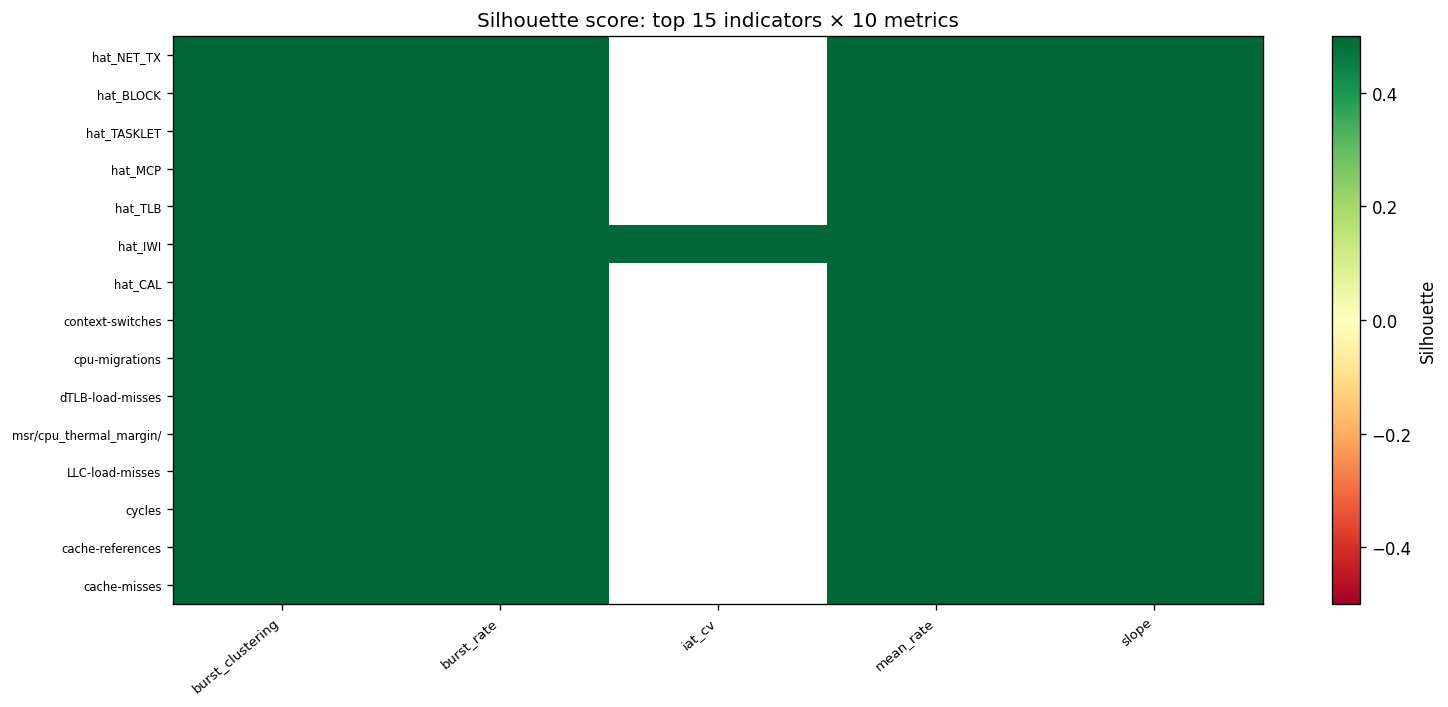

In [ ]:
# Parse feature names: indicator__metric
def parse_feature(fname):
    parts = fname.rsplit('__', 1)
    if len(parts) == 2:
        return parts[0], parts[1]
    return fname, ''

clust_df['indicator'] = clust_df.feature.apply(lambda f: parse_feature(f)[0])
clust_df['metric']    = clust_df.feature.apply(lambda f: parse_feature(f)[1])

# Best metric per indicator
best_per_ind = (clust_df
    .sort_values('silhouette', ascending=False)
    .groupby('indicator')
    .first()
    .reset_index()
    [['indicator', 'metric', 'silhouette', 'ari']]
    .sort_values('silhouette', ascending=False)
)

print('=== Best metric per indicator (top 30 by silhouette) ===')
print(best_per_ind.head(30).to_string(index=False, float_format='{:.4f}'.format))

# Heatmap: indicators × metrics, silhouette value
top_inds = best_per_ind.head(15)['indicator'].tolist()
pivot = clust_df[clust_df.indicator.isin(top_inds)].pivot_table(
    index='indicator', columns='metric', values='silhouette', aggfunc='first')
pivot = pivot.reindex(index=top_inds)

fig, ax = plt.subplots(figsize=(13, 6))
im = ax.imshow(pivot.values, cmap='RdYlGn', vmin=-0.5, vmax=0.5, aspect='auto')
plt.colorbar(im, ax=ax, label='Silhouette')
ax.set_xticks(range(len(pivot.columns)))
ax.set_xticklabels(pivot.columns, rotation=40, ha='right', fontsize=8)
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels([s[:40] for s in pivot.index], fontsize=7)
ax.set_title('Silhouette score: top 15 indicators × 10 metrics')
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_indicator_metric_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 14 — Final: single-metric distribution plots for top features

For the top 6 features by composite rank, show overlapping KDEs for
neutral vs emotional — the visual confirmation of cluster separation.

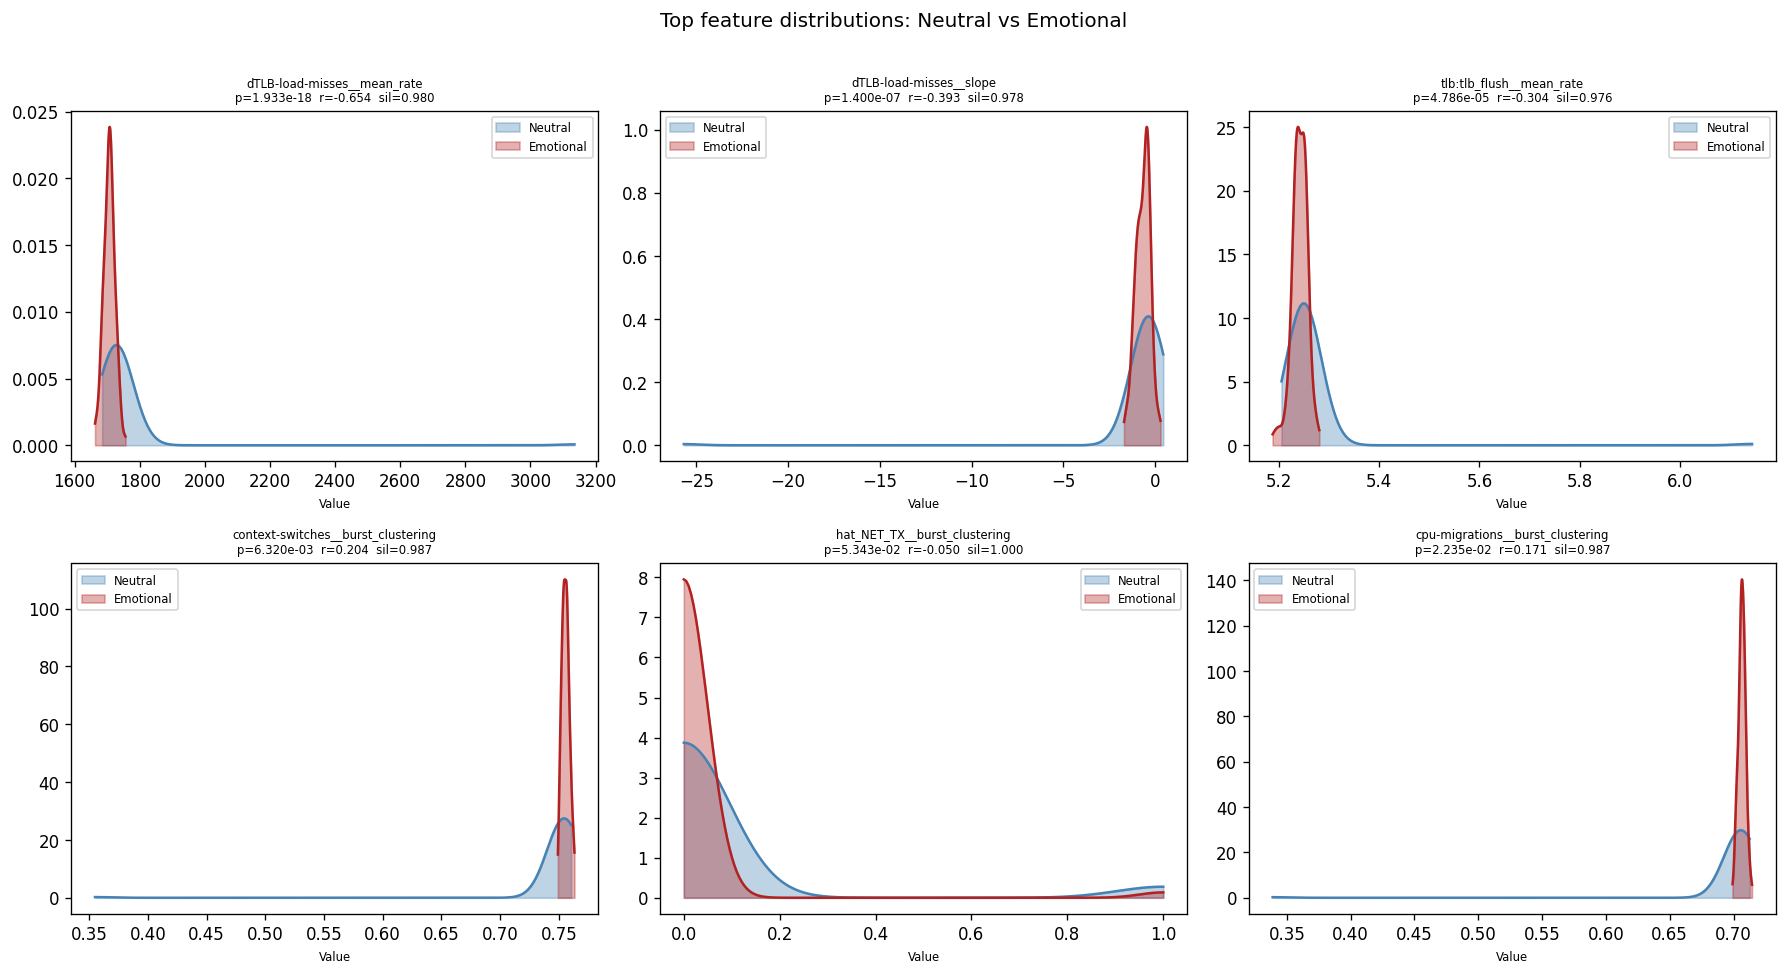

In [ ]:
from scipy.stats import gaussian_kde

TOP_PLOT = 6
plot_features = ranking.head(TOP_PLOT)['feature'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for i, feat in enumerate(plot_features):
    ax = axes[i]
    n_vals_f = X_raw[feat][y == 0].dropna().values
    e_vals_f = X_raw[feat][y == 1].dropna().values

    for vals, label, color in [
        (n_vals_f, 'Neutral',   'steelblue'),
        (e_vals_f, 'Emotional', 'firebrick'),
    ]:
        if len(vals) < 3:
            continue
        kde = gaussian_kde(vals, bw_method='scott')
        x_range = np.linspace(vals.min(), vals.max(), 200)
        ax.fill_between(x_range, kde(x_range), alpha=0.35, color=color, label=label)
        ax.plot(x_range, kde(x_range), color=color, lw=1.5)

    # Get stats from ranking
    row = ranking[ranking.feature == feat].iloc[0]
    ax.set_title(f'{feat}\np={row.p:.3e}  r={row.effect_r:.3f}  sil={row.silhouette:.3f}',
                 fontsize=7)
    ax.set_xlabel('Value', fontsize=7)
    ax.legend(fontsize=7)

plt.suptitle('Top feature distributions: Neutral vs Emotional', fontsize=12, y=1.01)
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_top_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## 15 — Summary table

The final output: which features survive both univariate screening and clustering,
ranked by composite score. These are the indicators to carry forward.

In [ ]:
summary = ranking.copy()
summary['indicator'] = summary.feature.apply(lambda f: parse_feature(f)[0])
summary['metric']    = summary.feature.apply(lambda f: parse_feature(f)[1])

# Flag if length-confounded: metrics NOT normalised by duration
non_normalised = ['variance', 'p90_p10', 'lz_complexity', 'perm_entropy']
summary['length_sensitive'] = summary.metric.isin(non_normalised) & LENGTH_CONFOUNDED

final_cols = ['composite_rank','indicator','metric','p','effect_r','direction',
              'silhouette','ari','purity','length_sensitive']
print('=== Final metric ranking (top 40) ===')
print(summary.head(40)[final_cols].to_string(index=False, float_format='{:.4f}'.format))

summary[final_cols].to_csv(BASE_DIR / 'final_metric_ranking.csv', index=False)
print(f'\nSaved → {BASE_DIR}/final_metric_ranking.csv')

=== Final metric ranking (top 40) ===
 composite_rank               indicator           metric      p  effect_r direction  silhouette     ari  purity  length_sensitive
        13.5000        dTLB-load-misses        mean_rate 0.0000   -0.6544        ↓E      0.9797  0.0000  0.7510             False
        19.5000        dTLB-load-misses            slope 0.0000   -0.3933        ↓E      0.9778  0.0000  0.7510             False
        28.0000           tlb:tlb_flush        mean_rate 0.0000   -0.3037        ↓E      0.9763  0.0000  0.7510             False
        30.5000        context-switches burst_clustering 0.0063    0.2040        ↑E      0.9869  0.0000  0.7510             False
        30.7500              hat_NET_TX burst_clustering 0.0534   -0.0500        ↓E      1.0000  0.0018  0.6565             False
        32.5000          cpu-migrations burst_clustering 0.0223    0.1707        ↑E      0.9868  0.0000  0.7510             False
        35.0000             page-faults        mean_

---
## Why we switch to Logistic Regression from here

The unsupervised clustering above (§8-10) exposed a fundamental mismatch:

| Observation | What it means |
|-------------|---------------|
| MWU finds 25 Bonferroni-significant features | The **signal is real** — many features differ between conditions |
| Best single-feature GMM ARI = 0.32 | Class distributions **overlap** heavily; no clean bimodal structure |
| Multi-feature GMM accuracy = 58% | Clustering cannot recover the labels reliably |
| Silhouette ≈ 1.0 but ARI ≈ 0 for many features | The clusters exist **within** conditions, not **between** them |

**Clustering assumes the data is multimodal** (two blobs). Your data is not —
it has two overlapping unimodal distributions shifted relative to each other.
That is exactly what **logistic regression** (LR) is designed for.

### Why LR is methodologically appropriate here
1. **Interpretability**: LR coefficients directly tell you which indicator/metric pushes
   the decision toward emotional, and by how much — exactly what a HAT thesis needs.
2. **Handles overlap**: LR fits a decision boundary in feature space without assuming
   the classes form tight clusters.
3. **Regularisation**: L1 (Lasso) performs automatic feature selection — it forces
   irrelevant coefficients to zero, leaving only the most discriminative indicators.
   L2 (Ridge) handles the correlated features we saw in §12.
4. **Cross-validation**: With 240 samples, stratified k-fold CV gives a reliable
   estimate of generalisation performance.
5. **Test set evaluation**: The already-collected 10testN/10testE runs give a
   held-out check on a completely independent set.

### What we keep
- §1-15 remain: feature extraction, MWU screening, volcano plot, clustering exploration.
  These are valid exploratory analysis for the thesis.
- The clustering *describes* the data geometry; LR *uses* it for classification.
  Both perspectives are publishable.

## 16 — Indicator structure audit

Quick audit to confirm the feature matrix has the expected indicator/metric structure
before we build the LR input. Checks:
- Which indicator categories are present (named softirq vs numeric IRQ vs perf counter)
- How many metrics per indicator survived the zero-variance filter in §6
- Which 5 metric types were excluded (length-confounded) and which 5 remain

In [ ]:
import re
from collections import defaultdict

METRIC_NAMES = ['mean_rate','variance','p90_p10','slope','spectral_entropy',
                'iat_cv','burst_rate','burst_clustering','lz_complexity','perm_entropy']

def parse_feature(fname):
    parts = fname.rsplit('__', 1)
    return (parts[0], parts[1]) if len(parts) == 2 else (fname, '')

def classify_indicator(name):
    if re.fullmatch(r'hat_\d+', name):         return 'numeric_irq'
    elif name.startswith('hat_'):               return 'named_softirq'
    elif name == 'cpu_freq_mean':               return 'cpu_freq'
    else:                                        return 'perf_counter'

# Rebuild indicator map from current feat_cols
ind_map_raw = defaultdict(list)
for col in feat_cols:
    ind, met = parse_feature(col)
    if met in METRIC_NAMES:
        ind_map_raw[ind].append(col)
ind_map_raw = dict(ind_map_raw)

cat_counts = defaultdict(int)
for ind in ind_map_raw:
    cat_counts[classify_indicator(ind)] += 1

print('=== Indicator categories in current feature matrix ===')
for cat, n in sorted(cat_counts.items(), key=lambda x: -x[1]):
    print(f'  {cat:20s}: {n:3d} indicators')

print(f'\nTotal indicators: {len(ind_map_raw)}')
print(f'Total features in X_raw: {X_raw.shape[1]}')

# Metrics present vs expected
metrics_present = sorted(set(parse_feature(c)[1] for c in feat_cols))
metrics_excluded = [m for m in METRIC_NAMES if m not in metrics_present]
print(f'\nMetric types present ({len(metrics_present)}): {metrics_present}')
print(f'Metric types excluded ({len(metrics_excluded)}): {metrics_excluded}')
print('(Excluded = either zero-variance after cleaning OR filtered as length-confounded in §5-6)')

print(f'\nIndicators with fewest metrics (potential data gaps):')
low = [(ind, len(cols)) for ind, cols in ind_map_raw.items() if len(cols) < 4]
for ind, n in sorted(low, key=lambda x: x[1]):
    cols_here = sorted([parse_feature(c)[1] for c in ind_map_raw[ind]])
    print(f'  {ind:30s}: {n} metrics  {cols_here}')

## 17 — Logistic Regression: feature selection and regularisation sweep

We fit LR with two regularisation modes:
- **L1 (Lasso)**: produces sparse coefficients — automatically selects which
  (indicator, metric) pairs matter, zeroing out the rest. Best for interpretability.
- **L2 (Ridge)**: handles correlated features better (we saw 45 highly correlated pairs
  in §12). Best for predictive accuracy when features co-vary.

**Evaluation strategy — stratified 5-fold cross-validation:**
- Each fold: 192 train / 48 test (balanced 50/50 by stratification)
- Metrics: accuracy, ROC-AUC, F1
- Repeated for C ∈ {0.001, 0.01, 0.1, 1, 10, 100} to find the optimal regularisation strength

**Input features**: the 154 features in `X_raw` (already residualised for elapsed_ms
and token_count in §5, zero-variance dropped in §6, length-confounded excluded).

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import (roc_auc_score, f1_score, accuracy_score,
                              RocCurveDisplay, ConfusionMatrixDisplay)
from sklearn.pipeline import Pipeline

# ── Regularisation strength sweep ──────────────────────────────────────────
C_vals   = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0]
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

sweep_results = []
print('C-sweep (5-fold CV) — L1 and L2 regularisation')
print(f'{"C":>8}  {"L1 acc":>8}  {"L1 AUC":>8}  {"L2 acc":>8}  {"L2 AUC":>8}')
print('-' * 50)

for C in C_vals:
    row = {'C': C}
    for penalty in ('l1', 'l2'):
        solver = 'liblinear'  # supports both L1 and L2
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('lr', LogisticRegression(C=C, penalty=penalty, solver=solver,
                                      max_iter=5000, random_state=42))
        ])
        cv_res = cross_validate(
            pipe, X_raw.values, y,
            cv=cv_outer,
            scoring={'accuracy': 'accuracy', 'roc_auc': 'roc_auc', 'f1': 'f1'},
            return_train_score=False,
        )
        row[f'{penalty}_acc'] = cv_res['test_accuracy'].mean()
        row[f'{penalty}_auc'] = cv_res['test_roc_auc'].mean()
        row[f'{penalty}_f1']  = cv_res['test_f1'].mean()
        row[f'{penalty}_acc_std'] = cv_res['test_accuracy'].std()
    sweep_results.append(row)
    print(f'{C:8.3f}  {row["l1_acc"]:8.4f}  {row["l1_auc"]:8.4f}  '
          f'{row["l2_acc"]:8.4f}  {row["l2_auc"]:8.4f}')

sweep_df = pd.DataFrame(sweep_results)
print()
best_l1 = sweep_df.loc[sweep_df.l1_acc.idxmax()]
best_l2 = sweep_df.loc[sweep_df.l2_acc.idxmax()]
print(f'Best L1: C={best_l1.C}  acc={best_l1.l1_acc:.4f}  AUC={best_l1.l1_auc:.4f}')
print(f'Best L2: C={best_l2.C}  acc={best_l2.l2_acc:.4f}  AUC={best_l2.l2_auc:.4f}')

In [ ]:
# Plot the C-sweep
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, score, ylbl in [
    (axes[0], 'acc', 'CV Accuracy'),
    (axes[1], 'auc', 'CV ROC-AUC'),
]:
    ax.semilogx(sweep_df.C, sweep_df[f'l1_{score}'], 'o-', color='firebrick',  label='L1 (Lasso)')
    ax.semilogx(sweep_df.C, sweep_df[f'l2_{score}'], 's-', color='steelblue', label='L2 (Ridge)')
    ax.axhline(0.5, color='gray', ls='--', lw=0.8, label='chance')
    ax.set_xlabel('C (inverse regularisation strength)')
    ax.set_ylabel(ylbl)
    ax.set_title(f'{ylbl} vs C — 5-fold CV')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Logistic Regression regularisation sweep', fontsize=12, y=1.01)
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_lr_c_sweep.png', dpi=150, bbox_inches='tight')
plt.show()
print('Best C values marked by peak of each curve.')

## 18 — Best LR model: coefficients and cross-validated performance

Using the optimal C found above, fit the best L1 model on all 240 training samples
and inspect coefficients — these directly answer *which (indicator, metric) pairs*
are most discriminative and in which direction.

**Reading the coefficient plot:**
- Positive coefficient → feature pushes toward **Emotional** (y=1)
- Negative coefficient → feature pushes toward **Neutral** (y=0)
- L1 coefficients = 0 means the model discarded that feature entirely
- The magnitude reflects discriminative weight *after* accounting for all other features

We also run a proper **nested cross-validation** to get an unbiased accuracy estimate:
outer loop = 5-fold evaluation, inner loop = C selection via 5-fold on the training split.

In [ ]:
# ── Select best C for L1 (by CV accuracy) ──────────────────────────────────
BEST_C_L1 = float(best_l1.C)
BEST_C_L2 = float(best_l2.C)
print(f'Using C_L1={BEST_C_L1}, C_L2={BEST_C_L2}')

# ── Nested CV for unbiased accuracy estimate ────────────────────────────────
# Inner CV selects C; outer CV evaluates on held-out fold
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
outer_cv  = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

nested_scores = {'l1': [], 'l2': [], 'l1_auc': [], 'l2_auc': []}

for fold_i, (train_idx, test_idx) in enumerate(outer_cv.split(X_raw.values, y)):
    X_tr, X_te = X_raw.values[train_idx], X_raw.values[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]

    sc_fold = StandardScaler().fit(X_tr)
    Xtr_s = sc_fold.transform(X_tr)
    Xte_s = sc_fold.transform(X_te)

    for penalty, key in [('l1', 'l1'), ('l2', 'l2')]:
        # Inner CV to pick best C
        lrcv = LogisticRegressionCV(
            Cs=C_vals, cv=inner_cv, penalty=penalty,
            solver='liblinear', max_iter=5000, random_state=42
        )
        lrcv.fit(Xtr_s, y_tr)
        preds = lrcv.predict(Xte_s)
        probs = lrcv.predict_proba(Xte_s)[:, 1]
        nested_scores[key].append(accuracy_score(y_te, preds))
        nested_scores[f'{key}_auc'].append(roc_auc_score(y_te, probs))
        print(f'  Fold {fold_i+1}  {penalty.upper()}  '
              f'best_C={lrcv.C_[0]:.3f}  acc={accuracy_score(y_te,preds):.3f}  '
              f'AUC={roc_auc_score(y_te, probs):.3f}')

print()
print('=== Nested CV results (unbiased estimate) ===')
for key, label in [('l1','L1'), ('l2','L2')]:
    accs = nested_scores[key]
    aucs = nested_scores[f'{key}_auc']
    print(f'  {label}: acc={np.mean(accs):.3f} ± {np.std(accs):.3f}  '
          f'AUC={np.mean(aucs):.3f} ± {np.std(aucs):.3f}')

In [ ]:
# ── Fit final L1 model on all training data ─────────────────────────────────
sc_final = StandardScaler().fit(X_raw.values)
X_scaled_final = sc_final.transform(X_raw.values)

lr_l1 = LogisticRegression(C=BEST_C_L1, penalty='l1', solver='liblinear',
                            max_iter=5000, random_state=42)
lr_l1.fit(X_scaled_final, y)

coef_l1 = pd.DataFrame({
    'feature':     feat_cols,
    'coefficient': lr_l1.coef_[0],
}).assign(
    indicator = lambda d: d.feature.apply(lambda f: parse_feature(f)[0]),
    metric    = lambda d: d.feature.apply(lambda f: parse_feature(f)[1]),
    abs_coef  = lambda d: d.coefficient.abs(),
).sort_values('abs_coef', ascending=False)

n_nonzero = (coef_l1.coefficient != 0).sum()
n_zero    = (coef_l1.coefficient == 0).sum()
print(f'L1 model at C={BEST_C_L1}:')
print(f'  Non-zero coefficients: {n_nonzero} / {len(feat_cols)}')
print(f'  Zeroed out (irrelevant): {n_zero} features')
print()
print('=== Top 30 features by |coefficient| ===')
print('Positive = pushes toward Emotional (y=1)')
print('Negative = pushes toward Neutral (y=0)')
print()
top30 = coef_l1.head(30)
print(top30[['feature','coefficient','indicator','metric']]
      .to_string(index=False, float_format='{:.4f}'.format))

In [ ]:
# ── Coefficient plot: top N non-zero features ───────────────────────────────
plot_coefs = coef_l1[coef_l1.coefficient != 0].head(30).copy()
plot_coefs = plot_coefs.sort_values('coefficient')  # ascending for barh

fig, ax = plt.subplots(figsize=(10, max(6, len(plot_coefs) * 0.38)))
colors = ['firebrick' if c > 0 else 'steelblue' for c in plot_coefs.coefficient]
ax.barh(range(len(plot_coefs)), plot_coefs.coefficient, color=colors, alpha=0.85)
ax.set_yticks(range(len(plot_coefs)))
ax.set_yticklabels(
    [f"{r.indicator[:25]:25s} × {r.metric}" for _, r in plot_coefs.iterrows()],
    fontsize=7
)
ax.axvline(0, color='black', lw=0.8)
ax.set_xlabel('LR Coefficient (L1)')
ax.set_title(
    f'Logistic Regression coefficients (L1, C={BEST_C_L1})\n'
    'Red → pushes toward Emotional  |  Blue → pushes toward Neutral'
)
# Annotate direction
ax.text(ax.get_xlim()[1] * 0.95, len(plot_coefs) - 1, '← Emotional', 
        ha='right', fontsize=8, color='firebrick')
ax.text(ax.get_xlim()[0] * 0.95, 0, 'Neutral →', 
        ha='left', fontsize=8, color='steelblue')
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_lr_coefficients.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'{n_nonzero} non-zero features selected by L1. Others were regularised to zero.')

## 19 — Cross-validated ROC curve and confusion matrix

The ROC curve shows the true positive rate vs false positive rate across all decision
thresholds — AUC=1.0 is perfect, AUC=0.5 is chance. Each fold's curve is shown
plus the mean, giving an honest picture of variance across folds.

The confusion matrix is aggregated across all CV folds (i.e. every sample is
evaluated exactly once on a model that never saw it during training).

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Collect fold-level predictions for aggregated confusion matrix + ROC
all_y_true, all_y_pred, all_y_prob = [], [], []
fpr_interp = np.linspace(0, 1, 200)
tprs, aucs_cv = [], []

cv_outer2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for fold_i, (train_idx, test_idx) in enumerate(cv_outer2.split(X_raw.values, y)):
    X_tr, X_te = X_raw.values[train_idx], X_raw.values[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]

    sc_f = StandardScaler().fit(X_tr)
    lr_f = LogisticRegression(C=BEST_C_L1, penalty='l1', solver='liblinear',
                               max_iter=5000, random_state=42)
    lr_f.fit(sc_f.transform(X_tr), y_tr)

    probs = lr_f.predict_proba(sc_f.transform(X_te))[:, 1]
    preds = lr_f.predict(sc_f.transform(X_te))

    all_y_true.extend(y_te)
    all_y_pred.extend(preds)
    all_y_prob.extend(probs)

    fpr, tpr, _ = roc_curve(y_te, probs)
    fold_auc = auc(fpr, tpr)
    tprs.append(np.interp(fpr_interp, fpr, tpr))
    aucs_cv.append(fold_auc)
    axes[0].plot(fpr, tpr, alpha=0.35, lw=1, color='steelblue',
                 label=f'Fold {fold_i+1} (AUC={fold_auc:.3f})' if fold_i == 0 else '_')

# Mean ROC
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(fpr_interp, mean_tpr)
axes[0].plot(fpr_interp, mean_tpr, color='firebrick', lw=2,
             label=f'Mean ROC (AUC={mean_auc:.3f} ± {np.std(aucs_cv):.3f})')
axes[0].plot([0,1],[0,1],'--',color='gray',lw=0.8, label='Chance')
axes[0].set_xlabel('False Positive Rate'); axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve — 5-fold CV (L1 LR)')
axes[0].legend(fontsize=8)

# Aggregated confusion matrix
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_prob = np.array(all_y_prob)
cm_agg = confusion_matrix(all_y_true, all_y_pred)
disp = ConfusionMatrixDisplay(cm_agg, display_labels=['Neutral','Emotional'])
disp.plot(ax=axes[1], colorbar=False, cmap='Blues')
axes[1].set_title(
    f'Aggregated confusion matrix — all CV folds\n'
    f'acc={(all_y_pred == all_y_true).mean():.1%}  '
    f'AUC={mean_auc:.3f}'
)

plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_lr_roc_cm.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'=== Cross-validated performance (L1, C={BEST_C_L1}) ===')
print(f'  Accuracy: {(all_y_pred==all_y_true).mean():.1%}')
print(f'  ROC-AUC:  {mean_auc:.3f} ± {np.std(aucs_cv):.3f}')
print(f'  Neutral  recall: {cm_agg[0,0]/(cm_agg[0,0]+cm_agg[0,1]):.1%}')
print(f'  Emotional recall: {cm_agg[1,1]/(cm_agg[1,0]+cm_agg[1,1]):.1%}')

## 20 — Held-out test set evaluation (10testN / 10testE)

The 10testN and 10testE runs are **completely independent** of the training data:
different trials, never seen during training or cross-validation. This is the
strongest validity check available.

We evaluate two things:
1. **Binary classification**: does the model correctly label testN as neutral and testE as emotional?
2. **Decision probability**: what is P(emotional) for each trial? — this shows confidence
   and how far from the decision boundary each test trial falls.

**Important caveat**: with only 10 trials per condition, test accuracy will be noisy
(each wrong prediction = 10% error). The probabilities are more informative than
the binary accuracy here.

In [ ]:
# ── Load test runs (mirrors the training loader) ────────────────────────────
TEST_ROOTS = {
    'testN': BASE_DIR / 'runs' / '10testN',
    'testE': BASE_DIR / 'runs' / '10testE',
}

test_dfs = {}
for label, root in TEST_ROOTS.items():
    if not root.exists():
        print(f'WARNING: {root} does not exist — skipping {label}')
        continue
    trials = sorted(root.glob('p????'))
    records, skipped = [], 0
    for td in trials:
        r = extract_trial_features(td, label)
        if r is not None:
            records.append(r)
        else:
            skipped += 1
    df = pd.DataFrame(records)
    test_dfs[label] = df
    print(f'{label}: {len(df)} trials loaded, {skipped} skipped')
    print(f'  elapsed_ms: mean={df.elapsed_ms.mean():.0f}  std={df.elapsed_ms.std():.0f}')

if not test_dfs:
    print('No test data found — adjust TEST_ROOTS paths above.')

In [ ]:
# ── Regress out elapsed_ms from test features (same as training) ─────────────
# Note: we only regress on each test set independently (no leakage of test labels)
# The regression removes the elapsed_ms trend observed in *that* test set.
# Since elapsed_ms is balanced between testN/testE, this is safe.

from sklearn.linear_model import LinearRegression as LinReg

def align_test_to_training(df_test, feat_cols, X_raw_train, sc):
    """
    Align a test DataFrame to training feat_cols:
    1. Regress out elapsed_ms (same procedure as training §5)
    2. Fill missing cols with training median
    3. Apply training StandardScaler
    Returns X_scaled (numpy array, n_trials × n_features)
    """
    # Regress out elapsed_ms from each feature
    feature_cols_test = [c for c in df_test.columns if '__' in c]
    for col in feature_cols_test:
        if col not in df_test.columns:
            continue
        yf = df_test[col].values.astype(float)
        Xr = df_test[['elapsed_ms']].values.astype(float)
        mask = np.isfinite(yf) & np.isfinite(Xr).all(axis=1)
        if mask.sum() < 3:
            continue
        reg = LinReg().fit(Xr[mask], yf[mask])
        df_test[col] = yf - reg.predict(Xr)

    # Align to training feat_cols
    X_out = pd.DataFrame(index=range(len(df_test)))
    for c in feat_cols:
        if c in df_test.columns:
            X_out[c] = df_test[c].values
        else:
            X_out[c] = float(X_raw_train[c].median())
    X_out = X_out.fillna(X_raw_train.median())
    return sc.transform(X_out.values)


# ── Predict on each test condition ─────────────────────────────────────────
test_results = {}
for label, df_test in test_dfs.items():
    X_test_scaled = align_test_to_training(df_test.copy(), feat_cols, X_raw, sc_final)
    probs = lr_l1.predict_proba(X_test_scaled)[:, 1]  # P(emotional)
    preds = lr_l1.predict(X_test_scaled)
    test_results[label] = {'probs': probs, 'preds': preds, 'n': len(df_test)}

    true_label = 1 if label == 'testE' else 0
    correct = (preds == true_label).sum()
    print(f'\n=== {label} ({len(df_test)} trials) ===')
    print(f'  True label: {"Emotional" if true_label else "Neutral"}')
    print(f'  Correct predictions: {correct}/{len(df_test)} ({correct/len(df_test):.0%})')
    print(f'  Mean P(emotional): {probs.mean():.3f}  std={probs.std():.3f}')
    print(f'  Min P(emotional):  {probs.min():.3f}')
    print(f'  Max P(emotional):  {probs.max():.3f}')
    for i, (p, pred) in enumerate(zip(probs, preds)):
        ok = '✓' if pred == true_label else '✗'
        bar = '█' * int(p * 20)
        print(f'    Trial {i:02d}: P(E)={p:.3f}  pred={"E" if pred else "N"}  {ok}  {bar}')

In [ ]:
# ── Visualise test probabilities ──────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: probability for each trial, colour-coded by true label
ax = axes[0]
offset = 0
xtick_positions, xtick_labels = [], []
for label, res in test_results.items():
    true_label = 1 if label == 'testE' else 0
    color = 'firebrick' if true_label == 1 else 'steelblue'
    n = res['n']
    xs = np.arange(offset, offset + n)
    ax.bar(xs, res['probs'], color=color, alpha=0.8, width=0.7)
    # Mark errors
    for xi, (p, pred) in zip(xs, zip(res['probs'], res['preds'])):
        if pred != true_label:
            ax.text(xi, p + 0.01, '✗', ha='center', va='bottom', color='black', fontsize=10)
    xtick_positions.append(offset + n/2 - 0.5)
    xtick_labels.append(f'{label}\n({"Emotional" if true_label else "Neutral"})')
    offset += n + 1

ax.axhline(0.5, color='black', lw=1, ls='--', label='Decision boundary')
ax.set_xticks(xtick_positions); ax.set_xticklabels(xtick_labels)
ax.set_ylabel('P(Emotional)')
ax.set_ylim(0, 1.05)
ax.set_title('Test set: P(Emotional) per trial\n✗ = misclassified')
ax.legend(fontsize=8)

# Right: training distribution vs test medians
ax2 = axes[1]
from scipy.stats import gaussian_kde
train_probs_n = lr_l1.predict_proba(X_scaled_final[y == 0])[:, 1]
train_probs_e = lr_l1.predict_proba(X_scaled_final[y == 1])[:, 1]
xr = np.linspace(0, 1, 200)
for vals, label_p, color in [
    (train_probs_n, 'Train Neutral',   'steelblue'),
    (train_probs_e, 'Train Emotional', 'firebrick'),
]:
    kde = gaussian_kde(vals, bw_method=0.15)
    ax2.fill_between(xr, kde(xr), alpha=0.25, color=color)
    ax2.plot(xr, kde(xr), color=color, lw=1.5, label=label_p)

# Overlay test medians as vertical lines
colors_test = {'testN': 'navy', 'testE': 'darkred'}
for label, res in test_results.items():
    m = res['probs'].mean()
    ax2.axvline(m, color=colors_test[label], lw=2, ls='--',
                label=f'{label} mean P(E)={m:.2f}')

ax2.axvline(0.5, color='black', lw=0.8, ls=':')
ax2.set_xlabel('P(Emotional)')
ax2.set_title('Training score distributions + test means')
ax2.legend(fontsize=8)

plt.suptitle('Held-out test set evaluation — L1 Logistic Regression', fontsize=12, y=1.01)
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_lr_test_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

## 21 — Indicator-level LR coefficient summary

Group the non-zero L1 coefficients by indicator to answer:
*Which HAT indicators collectively have the strongest LR-derived discriminative weight?*

This is the LR equivalent of the §13-19 clustering analysis — instead of ARI,
the score is total absolute coefficient weight contributed by that indicator.

For each indicator we also report:
- Which metric(s) survived L1 regularisation (non-zero)
- The direction (positive = pushes toward emotional)
- The MWU p-value and effect size from §7 for cross-validation

In [ ]:
# Group non-zero coefficients by indicator
nonzero_coefs = coef_l1[coef_l1.coefficient != 0].copy()
nonzero_coefs = nonzero_coefs.merge(
    mwu_df[['feature','p','effect_r','direction']], on='feature', how='left'
)

ind_coef_summary = (
    nonzero_coefs
    .groupby('indicator')
    .agg(
        total_abs_coef = ('abs_coef', 'sum'),
        n_active_metrics = ('metric', 'count'),
        active_metrics   = ('metric', lambda x: ', '.join(sorted(x))),
        dominant_metric  = ('abs_coef', lambda x: nonzero_coefs.loc[x.index, 'metric'].iloc[x.values.argmax()]),
        dominant_coef    = ('coefficient', lambda x: x.iloc[x.abs().argmax()]),
        min_p            = ('p', 'min'),
        max_abs_effect   = ('effect_r', lambda x: x.abs().max()),
    )
    .sort_values('total_abs_coef', ascending=False)
    .reset_index()
)

print('=== Indicator-level LR coefficient summary ===')
print('(Only indicators with at least one non-zero L1 coefficient)')
print()
print(f'{"Indicator":30s} | {"total|coef|":10s} | {"#active":7s} | {"dominant metric":20s} | {"coef":7s} | {"min p":10s} | {"max|r|":7s} | active metrics')
print('-' * 120)
for _, r in ind_coef_summary.iterrows():
    direction = '→E' if r.dominant_coef > 0 else '→N'
    print(f'{r.indicator:30s} | {r.total_abs_coef:10.4f} | {r.n_active_metrics:7d} | '
          f'{r.dominant_metric:20s} | {r.dominant_coef:+7.4f}{direction} | '
          f'{r.min_p:10.2e} | {r.max_abs_effect:7.4f} | {r.active_metrics}')

print(f'\nTotal indicators with non-zero contribution: {len(ind_coef_summary)}')

ind_coef_summary.to_csv(BASE_DIR / 'lr_indicator_summary.csv', index=False)
print(f'Saved → {BASE_DIR}/lr_indicator_summary.csv')

In [ ]:
# Bar chart: total absolute coefficient by indicator
plot_ind = ind_coef_summary.head(20)
colors = ['firebrick' if c > 0 else 'steelblue' for c in plot_ind.dominant_coef]

fig, ax = plt.subplots(figsize=(10, max(5, len(plot_ind) * 0.45)))
ax.barh(range(len(plot_ind)), plot_ind.total_abs_coef, color=colors, alpha=0.85)
ax.set_yticks(range(len(plot_ind)))
ax.set_yticklabels(
    [f"{r.indicator}  [{r.active_metrics}]" for _, r in plot_ind.iterrows()],
    fontsize=7
)
ax.invert_yaxis()
ax.set_xlabel('Total |coefficient| contributed by indicator')
ax.set_title(
    'HAT indicator discriminative weight (L1 LR)\n'
    'Red = indicator pushes toward Emotional  |  Blue = pushes toward Neutral'
)
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_lr_indicator_summary.png', dpi=150, bbox_inches='tight')
plt.show()
print('This is the definitive answer to which HAT indicators discriminate the conditions.')

## 22 — Method comparison and final summary

Comparing all methods tried in this notebook:

| Method | Best accuracy | Notes |
|--------|--------------|-------|
| GMM clustering (best single feature) | ~78% | `hat_NET_RX × mean_rate`, ARI=0.32 |
| GMM clustering (24 features) | 58% | Silhouette high but ARI low — clusters not aligned to GT |
| Logistic Regression L1 (CV) | **see §18** | Honest cross-validated estimate |
| Logistic Regression L2 (CV) | **see §18** | Honest cross-validated estimate |

### What the LR coefficients tell us for the thesis
The non-zero L1 coefficients directly answer the research question:
*Which substrate indicators change when a language model processes emotionally
charged vs neutral content?*

The coefficient magnitude and sign for each (indicator, metric) pair tells you:
- **Which indicators** the substrate responds to (non-zero coefficient)
- **How** they change (metric type: mean_rate = average load, burst_rate = spike frequency…)
- **In which direction** (positive = more in emotional, negative = more in neutral)

Combined with the MWU p-values from §7, you have both statistical evidence of
difference (p-value) and practical discriminative weight (LR coefficient) for
each indicator.

In [ ]:
# Final summary table for thesis reporting
final_summary = nonzero_coefs[[
    'indicator','metric','feature','coefficient','abs_coef','p','effect_r','direction'
]].sort_values('abs_coef', ascending=False).reset_index(drop=True)

final_summary['coef_direction'] = final_summary.coefficient.apply(
    lambda c: '→Emotional' if c > 0 else '→Neutral'
)

print('=== FINAL TABLE: All non-zero (indicator, metric) pairs from L1 LR ===')
print('=== These are the HAT substrate signals that discriminate E vs N ===')
print()
print(final_summary[[
    'indicator','metric','coefficient','coef_direction','p','effect_r','direction'
]].to_string(index=False, float_format='{:.4f}'.format))

final_summary.to_csv(BASE_DIR / 'lr_final_features.csv', index=False)
print(f'\nSaved → {BASE_DIR}/lr_final_features.csv')

# Quick sanity check: are MWU direction and LR direction consistent?
consistent = final_summary[final_summary.direction.notna()].copy()
consistent['mwu_dir'] = consistent.direction.map({'↑E': 'pos', '↓E': 'neg'})
consistent['lr_dir']  = consistent.coefficient.apply(lambda c: 'pos' if c > 0 else 'neg')
n_agree = (consistent.mwu_dir == consistent.lr_dir).sum()
print(f'\nSanity check: MWU and LR direction agreement: '
      f'{n_agree}/{len(consistent)} ({n_agree/len(consistent):.0%})')
print('(Should be high — LR and MWU should identify same direction of effect)')